# Various tests with adversarial data augmentation

In [1]:
# import
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from eevbnn.satenv import SolveResult
from eevbnn.eval_bin import ModelVerifier, init_argparser
from eevbnn.net_bin import BinLinear, BinConv2d, BinConv2dPos, BinLinearPos, InputQuantizer, MnistMLP, TernaryWeightWithMaskFn, SeqBinModelHelper, Binarize01Act, BatchNormStatsCallbak, setattr_inplace
from eevbnn.utils import Flatten, ModelHelper, torch_as_npy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pickle
import time
import random

from eevbnn_figures import *
from eevbnn_models import *
from eevbnn_verif import *
from eevbnn_augmentation import *


loss_fn = nn.CrossEntropyLoss()


/home/ben/Documents/Masters_thesis/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load MNIST dataset

train_set, test_set = load_data("MNIST")
train_fash, test_fash = load_data("Fashion")
train_cif, test_cif = load_data("CIFAR10")


---

Important notes :

- everything here is done with MNIST dataset
- 

In [4]:
input_size = 28*28
output_size = 10
quant_value = 0.1

In [ ]:

def get_trained_model_noadv(dname, model_types):
    train_set, test_set = load_data(dname)

    if dname == "CIFAR10":
        input_size = 32*32*3
        in_chan = 3
        mult = 8
    else:
        input_size = 28*28
        in_chan = 1
        mult = 7

    models_load = []
    for t in model_types:
        if t == 1:
            models_load.append(Model1(input_size, 10))
        elif t == 2:
            models_load.append(Model2(input_size, 10))
        elif t == 3:
            models_load.append(Model3(input_size, 10))
        else:
            models_load.append(Model4(in_chan, 10, mult))

    models = []
    for model in models_load:
        train_dataloader = DataLoader(train_set, batch_size=64)
        test_dataloader = DataLoader(test_set, batch_size=64)
        train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
        models.append(model.cvt_to_eval())
    
    return models



def graph_robust_eps(dname, models, eps_range, n=100):
    
    _, test_set = load_data(dname)

    scores = []
    times = []
    for eps in eps_range:
        print(f"running eps {eps}...", flush=True)
        args = get_args(eps, models)
        score = 0
        t = 0
        for i in range(n):
            img, label = test_set[i]
            t0 = time.perf_counter()
            check_res, adv = search_adv_img_multiple_models(models, img, label, get_classes(dname), args)
            t += time.perf_counter() - t0

            if check_res == SolveResult.SAT:
                score += 1
        scores.append(score / n)
        times.append(t / n)

        print(f"score : {score / n:.3f}")
        print(f"time  : {time / n:.3f}")
    
    return scores, times



dname = "MNIST"
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for i in range(1, 5):
    model_types = [i] * 5
    print("training models...", flush=True)
    models = get_trained_model_noadv(dname, model_types)

    scores, times = graph_robust_eps(dname, models, eps_range, n=100)

    with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_{dname}_m{i}.pickle", "wb") as file:
        pickle.dump(scores, file)
    with open(f"{FILEPATH}/saved_eps_graphs/sat_times_{dname}_m{i}.pickle", "wb") as file:
        pickle.dump(times, file)

    

# -----------------------------------------------------------------------------------------------------------

# mnist m1 cheat 05
with open(f"{FILEPATH}/saved_graphs/23_2_models_mnist05.pickle", 'rb') as file:
    models_cheat_mnist05 = pickle.load(file)

# mnist m1 gen 05
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_models_mnist.pickle", "rb") as file:
    models_gen_mnist05 = pickle.load(file)

# mnist m1 cheat 02
with open(f"{FILEPATH}/saved_generated_data/models_mnist02_cheat.pickle", "rb") as file:
    models_cheat_mnist02 = pickle.load(file)

# mnist m1 gen 02
## running... (test 26)

# mnist m4 cheat 05
with open(f"{FILEPATH}/saved_graphs/34_models_t4_mnist05.pickle", "rb") as file:
    models4_gen_mnist05 = pickle.load(file)

# mnist m4 gen 05
## running... (test 35)


# ---------------------------------

# fashion m1 cheat 05
with open(f"{FILEPATH}/saved_graphs/models_fashion05_cheat_2.pickle", 'rb') as file:
    models_cheat_fashion = pickle.load(file)

# fashion m1 gen 05
with open(f"{FILEPATH}/saved_graphs/27_models_fashion05.pickle", "rb") as file:
    models_gen_fashion = pickle.load(file)


# --------------------------------

# cifar m1 cheat 01
with open(f"{FILEPATH}/saved_graphs/31_models_cifar01.pickle", "rb") as file:
    models_cheat_cifar = pickle.load(file)

# cifar m1 gen 01
with open(f"{FILEPATH}/saved_graphs/29_models_gen_cifar01.pickle", "rb") as file:
    models_gen_cifar = pickle.load(file)






scores, times = graph_robust_eps("MNIST", models_gen_mnist05, eps_range, n=100)
with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_gen.pickle", 'wb') as file:
    pickle.dump(scores, file)
with open(f"{FILEPATH}/saved_eps_graphs/sat_times_MNIST_m1_gen.pickle", 'wb') as file:
    pickle.dump(times, file)



## accuracies

In [5]:
# MNIST - 1 model #

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)


for i in range(1, 5):
    if i == 1:
        model = Model1(28*28, 10)
    elif i == 2:
        model = Model2(28*28, 10)
    elif i == 3:
        model = Model3(28*28, 10)
    else:
        model = Model4(1, 10, 7)

    model = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    acc, _ = test(test_dataloader, model, loss_fn, verbose=False)

    print(f"MNIST - Model {i} : {acc}")
    with open(f"{FILEPATH}/saved_models_eevbnn/model{i}_mnist_epoch25.pickle", "wb") as file:
        pickle.dump(model, file)


MNIST - Model 1 : 0.9727
MNIST - Model 2 : 0.2304
MNIST - Model 3 : 0.9436
MNIST - Model 4 : 0.9729


In [12]:
# MNIST - majority voting #

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

for i in range(1, 5):
    models = []
    if i == 1:
        for j in range(5):
            models.append(Model1(28*28, 10))
    elif i == 2:
        for j in range(5):
            models.append(Model2(28*28, 10))
    elif i == 3:
        for j in range(5):
            models.append(Model3(28*28, 10))
    else:
        for j in range(5):
            models.append(Model4(1, 10, 7))

    for j in range(5):
        train_test_model(models[j], train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    dtest = Data(test_set)
    acc = evaluate_robustness_acc_majority_voting(models, dtest, "MNIST")

    print(f"MNIST - Models maj voting {i} : {acc:.3f}%")



MNIST - Models maj voting 1 : 97.870%
MNIST - Models maj voting 2 : 91.240%
MNIST - Models maj voting 3 : 96.170%
MNIST - Models maj voting 4 : 98.650%


In [6]:
# FASHION - 1 model #

train_dataloader = DataLoader(train_fash, batch_size=64)
test_dataloader = DataLoader(test_fash, batch_size=64)


for i in range(1, 5):
    if i == 1:
        model = Model1(28*28, 10)
    elif i == 2:
        model = Model2(28*28, 10)
    elif i == 3:
        model = Model3(28*28, 10)
    else:
        model = Model4(1, 10, 7)

    model = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    acc, _ = test(test_dataloader, model, loss_fn, verbose=False)

    print(f"FASHION - Model {i} : {acc}")
    with open(f"{FILEPATH}/saved_models_eevbnn/model{i}_fashion_epoch25.pickle", "wb") as file:
        pickle.dump(model, file)

FASHION - Model 1 : 0.8669
FASHION - Model 2 : 0.7085
FASHION - Model 3 : 0.8521
FASHION - Model 4 : 0.8936


In [14]:
# FASHION - maj voting #

train_dataloader = DataLoader(train_fash, batch_size=64)
test_dataloader = DataLoader(test_fash, batch_size=64)

for i in range(1, 5):
    models = []
    if i == 1:
        for j in range(5):
            models.append(Model1(28*28, 10))
    elif i == 2:
        for j in range(5):
            models.append(Model2(28*28, 10))
    elif i == 3:
        for j in range(5):
            models.append(Model3(28*28, 10))
    else:
        for j in range(5):
            models.append(Model4(1, 10, 7))

    for j in range(5):
        train_test_model(models[j], train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    dtest = Data(test_fash)
    acc = evaluate_robustness_acc_majority_voting(models, dtest, "Fashion")

    print(f"FASHION - Models maj voting {i} : {acc:.3f}%")

FASHION - Models maj voting 1 : 88.180%
FASHION - Models maj voting 2 : 78.190%
FASHION - Models maj voting 3 : 87.360%
FASHION - Models maj voting 4 : 90.890%


In [8]:
# CIFAR - 1 model #

train_dataloader = DataLoader(train_cif, batch_size=64)
test_dataloader = DataLoader(test_cif, batch_size=64)


for i in range(1, 5):
    if i == 1:
        model = Model1(32*32*3, 10)
    elif i == 2:
        model = Model2(32*32*3, 10)
    elif i == 3:
        model = Model3(32*32*3, 10)
    else:
        model = Model4(3, 10, 8)

    model = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    acc, _ = test(test_dataloader, model, loss_fn, verbose=False)

    print(f"CIFAR10 - Model {i} : {acc}")
    with open(f"{FILEPATH}/saved_models_eevbnn/model{i}_cifar_epoch25.pickle", "wb") as file:
        pickle.dump(model, file)

CIFAR10 - Model 1 : 0.4776
CIFAR10 - Model 2 : 0.3836
CIFAR10 - Model 3 : 0.4514
CIFAR10 - Model 4 : 0.5538


In [5]:
# CIFAR - majority voting #

train_dataloader = DataLoader(train_cif, batch_size=64)
test_dataloader = DataLoader(test_cif, batch_size=64)

for i in range(1, 5):
    models = []
    if i == 1:
        for j in range(5):
            models.append(Model1(32*32*3, 10))
    elif i == 2:
        for j in range(5):
            models.append(Model2(32*32*3, 10))
    elif i == 3:
        for j in range(5):
            models.append(Model3(32*32*3, 10))
    else:
        for j in range(5):
            models.append(Model4(3, 10, 8))

    for j in range(5):
        train_test_model(models[j], train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    dtest = Data(test_cif)
    acc = evaluate_robustness_acc_majority_voting(models, dtest, "CIFAR10")

    print(f"CIFAR10 - Models maj voting {i} : {acc:.3f}%")
    with open(f"{FILEPATH}/saved_models_eevbnn/model{i}_cifar_epoch25_maj.pickle", "wb") as file:
        pickle.dump(models, file)


CIFAR10 - Models maj voting 1 : 52.780%
CIFAR10 - Models maj voting 2 : 43.030%
CIFAR10 - Models maj voting 3 : 49.770%
CIFAR10 - Models maj voting 4 : 64.990%


## Utils

In [3]:
def get_args_jupyter(eps, model):
    parser = argparse.ArgumentParser(
        description='evaluate robustness of 0/1 binaried network',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    init_argparser(parser)
    parser.add_argument('-e', '--eps', type=float, default=eps,    # classical value : 0.08
                        help='adv input eps on 0-1 scale')          # nb : modif from file required=True -> default=0.08
    parser.add_argument('--model', default=model)
    
    args = parser.parse_args(" ".split())
    return args

In [6]:
def evaluate_robustness(model, dataset_name, eps=0.5, n_imgs=100, imgs=None):
    """
    Evaluate robustness of a model.
    For n_imgs images, computes the percentage of SAT cases (number of times we found an adversarial image)
    Uses the provided eps value.
    If search reaches time out, consider it as robust (UNSAT)

    Parameters:
        - model : the model whose robustness is evaluated
        - dataset_name : the name of the dataset used
        - eps : the epsilon value used when searching adversarial images
        - n_imgs : the number of images to consider to compute the SAT ratio
        - imgs : the images to use for the verification, format : [(image, label)]. Uses random indexes if None
    """
    model = model.cvt_to_eval()
    count = 0
    args = get_args_jupyter(eps, model)
    classes = get_classes(dataset_name)
    _, test_set = load_data(dataset_name)

    img, true_label = None, None

    if imgs is None:
        imgs = []
        for _ in range(n_imgs):
            idx = random.randint(0, len(test_set)-1)
            img, true_label = test_set[idx]
            imgs.append((img, true_label))
            
    for img, true_label in imgs:
        check_result, adv_img = search_adv_image(model, img, true_label, classes, args)
        if check_result == SolveResult.SAT:
            count += 1

    return count / len(imgs)

In [7]:
imgs_robust = []
for i in range(100):
    imgs_robust.append(test_set[i])

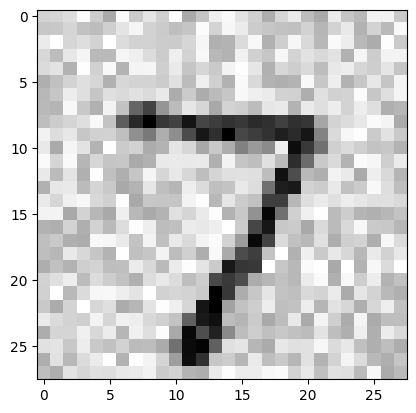

In [21]:
import random

def create_noise(dim, low, up):
    """dim : (channel, x, y)"""
    noise = np.zeros(dim)
    for c in range(dim[0]):
        for x in range(dim[1]):
            for y in range(dim[2]):
                noise[c, x, y] += random.uniform(low, up)
    return noise

noise = create_noise((1, 28, 28), 0, 0.5)
im = test_set[0][0]
im += noise


plt.imshow(im.squeeze(), cmap="gray_r")


9


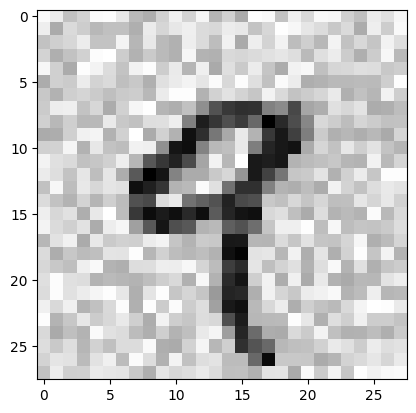

In [32]:
with open(f"{FILEPATH}/test_random_imgs.pickle", "rb") as file:
    d = pickle.load(file)

i = 4
plt.imshow(d[i][0].squeeze(), cmap="gray_r")
print(d[i][1])

## Reference
#### Train model on the normal train set

In [5]:
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)

Epoch 1
------------------------------
loss : 2.853804 [    0/60000]
loss : 0.543182 [ 6400/60000]
loss : 0.539548 [12800/60000]
loss : 0.470179 [19200/60000]
loss : 0.360440 [25600/60000]
loss : 0.429476 [32000/60000]
loss : 0.207869 [38400/60000]
loss : 0.500932 [44800/60000]
loss : 0.232616 [51200/60000]
loss : 0.286182 [57600/60000]
Test error: 
 Accuracy: 93.2%   Avg loss: 0.263637
Epoch 2
------------------------------
loss : 0.211591 [    0/60000]
loss : 0.242084 [ 6400/60000]
loss : 0.222261 [12800/60000]
loss : 0.166937 [19200/60000]
loss : 0.250229 [25600/60000]
loss : 0.277309 [32000/60000]
loss : 0.114132 [38400/60000]
loss : 0.352138 [44800/60000]
loss : 0.132635 [51200/60000]
loss : 0.220604 [57600/60000]
Test error: 
 Accuracy: 94.5%   Avg loss: 0.197014
Epoch 3
------------------------------
loss : 0.139181 [    0/60000]
loss : 0.151208 [ 6400/60000]
loss : 0.124289 [12800/60000]
loss : 0.172989 [19200/60000]
loss : 0.107098 [25600/60000]
loss : 0.209811 [32000/60000]
l

In [15]:
# compute robustness

t0 = time.perf_counter()
imgs = []
for i in range(100):
    imgs.append(test_set[i])

robustness = evaluate_robustness(model, "MNIST", eps=0.3, imgs=imgs)

print(f"robustness = {robustness}")
print(f"time : {time.perf_counter() - t0:.3f}")


# eps=0.5 => 90s,  robust 0.97 (/100)
# eps=0.4 => 96s,  robust 0.97 (/100)
# eps=0.3 => 166s, robust 0.96 (/100)
# eps=0.2 => 860s, robust 0.89 (/100)


robustness = 0.96
time : 166.441


## Test 1
#### full train set with small set of adversarial images, train model from scratch

In [25]:
dtrain = Data(train_set)
dtest = Data(test_set)

imgs_select = []
for i in range(10):
    idx = random.randint(0, len(adv_imgs))
    imgs_select.append(adv_imgs[idx])

dtrain.augment(imgs_select, shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader = DataLoader(dtrain, batch_size=64)
test_dataloader  = DataLoader(dtest, batch_size=64)

Size of train set : 60010
Size of test set  : 10000


In [26]:
## first test with only 5 epochs (as before)

model = Model1(input_size, output_size, quant_value)

_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)

Epoch 1
------------------------------
loss : 2.903667 [    0/60010]
loss : 0.515583 [ 6400/60010]
loss : 0.424263 [12800/60010]
loss : 0.295165 [19200/60010]
loss : 0.531269 [25600/60010]
loss : 0.242309 [32000/60010]
loss : 0.447290 [38400/60010]
loss : 0.152366 [44800/60010]
loss : 0.371823 [51200/60010]
loss : 0.185067 [57600/60010]
Test error: 
 Accuracy: 95.2%   Avg loss: 0.209480
Epoch 2
------------------------------
loss : 0.201040 [    0/60010]
loss : 0.185950 [ 6400/60010]
loss : 0.194934 [12800/60010]
loss : 0.081541 [19200/60010]
loss : 0.320245 [25600/60010]
loss : 0.144639 [32000/60010]
loss : 0.305655 [38400/60010]
loss : 0.066127 [44800/60010]
loss : 0.201882 [51200/60010]
loss : 0.063192 [57600/60010]
Test error: 
 Accuracy: 96.1%   Avg loss: 0.152025
Epoch 3
------------------------------
loss : 0.111569 [    0/60010]
loss : 0.098453 [ 6400/60010]
loss : 0.148497 [12800/60010]
loss : 0.052114 [19200/60010]
loss : 0.215512 [25600/60010]
loss : 0.044671 [32000/60010]
l

In [11]:
## test with more epochs (25)

model = Model1(input_size, output_size, quant_value)

_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.715296 [    0/60010]
loss : 0.563536 [ 6400/60010]
loss : 0.472608 [12800/60010]
loss : 0.448871 [19200/60010]
loss : 0.400290 [25600/60010]
loss : 0.408294 [32000/60010]
loss : 0.206819 [38400/60010]
loss : 0.434442 [44800/60010]
loss : 0.242130 [51200/60010]
loss : 0.268101 [57600/60010]
Test error: 
 Accuracy: 61.8%   Avg loss: 1.095870
Epoch 2
------------------------------
loss : 0.198127 [    0/60010]
loss : 0.192822 [ 6400/60010]
loss : 0.176858 [12800/60010]
loss : 0.164372 [19200/60010]
loss : 0.131553 [25600/60010]
loss : 0.257126 [32000/60010]
loss : 0.137269 [38400/60010]
loss : 0.307891 [44800/60010]
loss : 0.165124 [51200/60010]
loss : 0.174050 [57600/60010]
Test error: 
 Accuracy: 13.8%   Avg loss: 3.135605
Epoch 3
------------------------------
loss : 0.067610 [    0/60010]
loss : 0.165891 [ 6400/60010]
loss : 0.128584 [12800/60010]
loss : 0.146131 [19200/60010]
loss : 0.077391 [25600/60010]
loss : 0.241714 [32000/60010]
l

Observations

only a few adversarial examples in the dataset lead to poor performances and a non stable BNN even with many epochs

## Test 2
#### Train with small part of train set and corresponding adversarial images, train model from scratch

In [13]:
dtrain = Data(train_set, limit=1000)
dtest = Data(test_set, limit=2000)

dtrain.augment(adv_imgs[:1000])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)


Size of train set : 2000
Size of test set  : 2000


In [14]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.634510 [    0/ 2000]
Test error: 
 Accuracy: 33.5%   Avg loss: 1.922459
Epoch 2
------------------------------
loss : 0.603600 [    0/ 2000]
Test error: 
 Accuracy: 35.2%   Avg loss: 1.826326
Epoch 3
------------------------------
loss : 0.361099 [    0/ 2000]
Test error: 
 Accuracy: 59.6%   Avg loss: 1.272736
Epoch 4
------------------------------
loss : 0.317240 [    0/ 2000]
Test error: 
 Accuracy: 62.2%   Avg loss: 1.449754
Epoch 5
------------------------------
loss : 0.239978 [    0/ 2000]
Test error: 
 Accuracy: 26.5%   Avg loss: 2.125065
Epoch 6
------------------------------
loss : 0.214644 [    0/ 2000]
Test error: 
 Accuracy: 62.0%   Avg loss: 1.398039
Epoch 7
------------------------------
loss : 0.193461 [    0/ 2000]
Test error: 
 Accuracy: 75.5%   Avg loss: 0.933634
Epoch 8
------------------------------
loss : 0.182455 [    0/ 2000]
Test error: 
 Accuracy: 82.8%   Avg loss: 0.696368
Epoch 9
------------------------------
l

In [15]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)


Size of train set : 10000
Size of test set  : 10000


In [16]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.939641 [    0/10000]
loss : 0.483418 [ 6400/10000]
Test error: 
 Accuracy: 85.1%   Avg loss: 0.641697
Epoch 2
------------------------------
loss : 0.412954 [    0/10000]
loss : 0.230862 [ 6400/10000]
Test error: 
 Accuracy: 75.2%   Avg loss: 0.870441
Epoch 3
------------------------------
loss : 0.240616 [    0/10000]
loss : 0.136489 [ 6400/10000]
Test error: 
 Accuracy: 84.4%   Avg loss: 0.595691
Epoch 4
------------------------------
loss : 0.124610 [    0/10000]
loss : 0.091596 [ 6400/10000]
Test error: 
 Accuracy: 84.2%   Avg loss: 0.616529
Epoch 5
------------------------------
loss : 0.083480 [    0/10000]
loss : 0.080171 [ 6400/10000]
Test error: 
 Accuracy: 82.7%   Avg loss: 0.628381
Epoch 6
------------------------------
loss : 0.065467 [    0/10000]
loss : 0.066246 [ 6400/10000]
Test error: 
 Accuracy: 75.8%   Avg loss: 0.821752
Epoch 7
------------------------------
loss : 0.062365 [    0/10000]
loss : 0.041108 [ 6400/10000]
T

In [17]:
dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 18766
Size of test set  : 10000


In [18]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.925625 [    0/18766]
loss : 0.567880 [ 6400/18766]
loss : 0.414308 [12800/18766]
Test error: 
 Accuracy: 88.5%   Avg loss: 0.514896
Epoch 2
------------------------------
loss : 0.301136 [    0/18766]
loss : 0.296645 [ 6400/18766]
loss : 0.225806 [12800/18766]
Test error: 
 Accuracy: 86.2%   Avg loss: 0.526387
Epoch 3
------------------------------
loss : 0.163676 [    0/18766]
loss : 0.185136 [ 6400/18766]
loss : 0.114079 [12800/18766]
Test error: 
 Accuracy: 90.0%   Avg loss: 0.374898
Epoch 4
------------------------------
loss : 0.117151 [    0/18766]
loss : 0.143431 [ 6400/18766]
loss : 0.085176 [12800/18766]
Test error: 
 Accuracy: 65.2%   Avg loss: 1.260042
Epoch 5
------------------------------
loss : 0.046150 [    0/18766]
loss : 0.074304 [ 6400/18766]
loss : 0.058969 [12800/18766]
Test error: 
 Accuracy: 90.0%   Avg loss: 0.368372
Epoch 6
------------------------------
loss : 0.091954 [    0/18766]
loss : 0.075760 [ 6400/18766]
l

Observation

- Using 2000 samples (1000/1000) leads to lower acc but may be only due to less images
- Using the same number and corresponding images lead to a small loss of acc (~5%)
- 



## Test 3
#### Take a fully trained model and continue its training with adversarial images

In [6]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 5000
Size of test set  : 10000


In [7]:
model = Model1(input_size, output_size, quant_value)
model = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)

Epoch 1
------------------------------
loss : 2.853804 [    0/ 5000]
Test error: 
 Accuracy: 87.2%   Avg loss: 0.629707
Epoch 2
------------------------------
loss : 0.511586 [    0/ 5000]
Test error: 
 Accuracy: 90.0%   Avg loss: 0.512256
Epoch 3
------------------------------
loss : 0.368588 [    0/ 5000]
Test error: 
 Accuracy: 90.4%   Avg loss: 0.466235
Epoch 4
------------------------------
loss : 0.264968 [    0/ 5000]
Test error: 
 Accuracy: 91.8%   Avg loss: 0.397860
Epoch 5
------------------------------
loss : 0.200269 [    0/ 5000]
Test error: 
 Accuracy: 90.0%   Avg loss: 0.424200


In [8]:
dtrain = Data(adv_imgs, limit=5000)
train_dataloader    = DataLoader(dtrain, batch_size=64)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

Size of train set : 5000
Size of test set  : 10000


In [9]:
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 0.173964 [    0/ 5000]
Test error: 
 Accuracy: 84.5%   Avg loss: 0.573491
Epoch 2
------------------------------
loss : 0.218932 [    0/ 5000]
Test error: 
 Accuracy: 89.3%   Avg loss: 0.414980
Epoch 3
------------------------------
loss : 0.091804 [    0/ 5000]
Test error: 
 Accuracy: 91.0%   Avg loss: 0.349074
Epoch 4
------------------------------
loss : 0.073984 [    0/ 5000]
Test error: 
 Accuracy: 91.8%   Avg loss: 0.328897
Epoch 5
------------------------------
loss : 0.055738 [    0/ 5000]
Test error: 
 Accuracy: 91.1%   Avg loss: 0.339003
Epoch 6
------------------------------
loss : 0.045883 [    0/ 5000]
Test error: 
 Accuracy: 92.3%   Avg loss: 0.295231
Epoch 7
------------------------------
loss : 0.038390 [    0/ 5000]
Test error: 
 Accuracy: 90.7%   Avg loss: 0.343461
Epoch 8
------------------------------
loss : 0.035612 [    0/ 5000]
Test error: 
 Accuracy: 91.7%   Avg loss: 0.313875
Epoch 9
------------------------------
l

Observations

- with the same number of adversarial images, acc does not seem to change very much

## Test 4
#### train only on adversarial images and test on adversarial images

In [10]:
dtrain = Data(adv_imgs, limit=5000)
dtest = Data(adv_imgs[5000:])

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 5000
Size of test set  : 3766


In [12]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.560421 [    0/ 5000]
Test error: 
 Accuracy: 89.5%   Avg loss: 0.586891
Epoch 2
------------------------------
loss : 0.505840 [    0/ 5000]
Test error: 
 Accuracy: 89.4%   Avg loss: 0.527255
Epoch 3
------------------------------
loss : 0.372021 [    0/ 5000]
Test error: 
 Accuracy: 89.9%   Avg loss: 0.473937
Epoch 4
------------------------------
loss : 0.235851 [    0/ 5000]
Test error: 
 Accuracy: 91.3%   Avg loss: 0.420418
Epoch 5
------------------------------
loss : 0.166521 [    0/ 5000]
Test error: 
 Accuracy: 91.4%   Avg loss: 0.395435
Epoch 6
------------------------------
loss : 0.146250 [    0/ 5000]
Test error: 
 Accuracy: 92.0%   Avg loss: 0.353027
Epoch 7
------------------------------
loss : 0.105743 [    0/ 5000]
Test error: 
 Accuracy: 91.7%   Avg loss: 0.334853
Epoch 8
------------------------------
loss : 0.089548 [    0/ 5000]
Test error: 
 Accuracy: 92.8%   Avg loss: 0.309848
Epoch 9
------------------------------
l

Observations

- when trained and tested with only adversarial images, the model has a similar behaviour than with normal data with just a bit less of acc (but could be due to less samples)

## Test 5
#### train only on adversarial images and test on both original and adv images

In [13]:
dtrain = Data(adv_imgs, limit=6000)
dtest = Data(test_set, limit=5000)

dtest.augment(adv_imgs[6000:])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 6000
Size of test set  : 7766


In [14]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.876643 [    0/ 6000]
Test error: 
 Accuracy: 83.9%   Avg loss: 0.715950
Epoch 2
------------------------------
loss : 0.480218 [    0/ 6000]
Test error: 
 Accuracy: 85.4%   Avg loss: 0.621335
Epoch 3
------------------------------
loss : 0.365844 [    0/ 6000]
Test error: 
 Accuracy: 85.0%   Avg loss: 0.621092
Epoch 4
------------------------------
loss : 0.282374 [    0/ 6000]
Test error: 
 Accuracy: 87.3%   Avg loss: 0.521423
Epoch 5
------------------------------
loss : 0.211953 [    0/ 6000]
Test error: 
 Accuracy: 87.0%   Avg loss: 0.509958
Epoch 6
------------------------------
loss : 0.124672 [    0/ 6000]
Test error: 
 Accuracy: 89.0%   Avg loss: 0.440569
Epoch 7
------------------------------
loss : 0.109143 [    0/ 6000]
Test error: 
 Accuracy: 87.5%   Avg loss: 0.481692
Epoch 8
------------------------------
loss : 0.080900 [    0/ 6000]
Test error: 
 Accuracy: 86.9%   Avg loss: 0.487057
Epoch 9
------------------------------
l

Observations

- when trained with only adversarial images and test on both, the acc obtained is lower than before. The normal images may act as the new adversarial images but with less impact (easier to process as no huge variation)

## Test 6
#### train on adversarial images and test only on original images

In [15]:
dtrain = Data(adv_imgs)
dtest = Data(test_set)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 8766
Size of test set  : 10000


In [16]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.696965 [    0/ 8766]
loss : 0.563581 [ 6400/ 8766]
Test error: 
 Accuracy: 87.9%   Avg loss: 0.603724
Epoch 2
------------------------------
loss : 0.447314 [    0/ 8766]
loss : 0.339303 [ 6400/ 8766]
Test error: 
 Accuracy: 88.6%   Avg loss: 0.512560
Epoch 3
------------------------------
loss : 0.278958 [    0/ 8766]
loss : 0.238779 [ 6400/ 8766]
Test error: 
 Accuracy: 88.2%   Avg loss: 0.511892
Epoch 4
------------------------------
loss : 0.199388 [    0/ 8766]
loss : 0.180997 [ 6400/ 8766]
Test error: 
 Accuracy: 87.5%   Avg loss: 0.485504
Epoch 5
------------------------------
loss : 0.150688 [    0/ 8766]
loss : 0.126478 [ 6400/ 8766]
Test error: 
 Accuracy: 89.3%   Avg loss: 0.416160
Epoch 6
------------------------------
loss : 0.108199 [    0/ 8766]
loss : 0.089392 [ 6400/ 8766]
Test error: 
 Accuracy: 90.0%   Avg loss: 0.383387
Epoch 7
------------------------------
loss : 0.077411 [    0/ 8766]
loss : 0.065875 [ 6400/ 8766]
T

Observations

- same as test 5, reach a better acc possibly because we have more samples

## Test 7
#### Train with adversarial images from another model

In [17]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 10000


In [19]:
model = Model4(1, output_size, 7, quant_value=quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.705589 [    0/10000]
loss : 0.412156 [ 6400/10000]
Test error: 
 Accuracy: 93.2%   Avg loss: 0.450201
Epoch 2
------------------------------
loss : 0.398308 [    0/10000]
loss : 0.253425 [ 6400/10000]
Test error: 
 Accuracy: 93.5%   Avg loss: 0.395766
Epoch 3
------------------------------
loss : 0.209305 [    0/10000]
loss : 0.150041 [ 6400/10000]
Test error: 
 Accuracy: 82.8%   Avg loss: 0.628713
Epoch 4
------------------------------
loss : 0.146911 [    0/10000]
loss : 0.119455 [ 6400/10000]
Test error: 
 Accuracy: 93.9%   Avg loss: 0.276439
Epoch 5
------------------------------
loss : 0.092943 [    0/10000]
loss : 0.079362 [ 6400/10000]
Test error: 
 Accuracy: 95.5%   Avg loss: 0.210182
Epoch 6
------------------------------
loss : 0.074848 [    0/10000]
loss : 0.067561 [ 6400/10000]
Test error: 
 Accuracy: 95.8%   Avg loss: 0.189217
Epoch 7
------------------------------
loss : 0.049551 [    0/10000]
loss : 0.050484 [ 6400/10000]
T

Observations

- training is as usual but final acc is lower (~5%) BUT still some (major) drops during training

## Test 8
#### train on original data and test on adv img

In [9]:
dtrain = Data(train_set)
dtest = Data(adv_imgs)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 60000
Size of test set  : 8766


In [11]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)

Epoch 1
------------------------------
loss : 2.865438 [    0/60000]
loss : 0.549832 [ 6400/60000]
loss : 0.543566 [12800/60000]
loss : 0.434974 [19200/60000]
loss : 0.369187 [25600/60000]
loss : 0.400135 [32000/60000]
loss : 0.257585 [38400/60000]
loss : 0.379745 [44800/60000]
loss : 0.232256 [51200/60000]
loss : 0.300170 [57600/60000]
Test error: 
 Accuracy: 59.6%   Avg loss: 1.180871
Epoch 2
------------------------------
loss : 0.152392 [    0/60000]
loss : 0.194936 [ 6400/60000]
loss : 0.180358 [12800/60000]
loss : 0.180010 [19200/60000]
loss : 0.165034 [25600/60000]
loss : 0.344928 [32000/60000]
loss : 0.122742 [38400/60000]
loss : 0.403542 [44800/60000]
loss : 0.166518 [51200/60000]
loss : 0.181198 [57600/60000]
Test error: 
 Accuracy: 54.1%   Avg loss: 1.479034
Epoch 3
------------------------------
loss : 0.080058 [    0/60000]
loss : 0.148026 [ 6400/60000]
loss : 0.130896 [12800/60000]
loss : 0.143507 [19200/60000]
loss : 0.123282 [25600/60000]
loss : 0.271291 [32000/60000]
l

In [4]:
dtrain = Data(train_set, limit=10000)
dtest = Data(adv_imgs)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 8766


In [7]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)

Epoch 1
------------------------------
loss : 2.853804 [    0/10000]
loss : 0.543182 [ 6400/10000]
Test error: 
 Accuracy: 70.6%   Avg loss: 1.025862
Epoch 2
------------------------------
loss : 0.431269 [    0/10000]
loss : 0.323747 [ 6400/10000]
Test error: 
 Accuracy: 65.2%   Avg loss: 1.178973
Epoch 3
------------------------------
loss : 0.293398 [    0/10000]
loss : 0.237010 [ 6400/10000]
Test error: 
 Accuracy: 64.5%   Avg loss: 1.140616
Epoch 4
------------------------------
loss : 0.188681 [    0/10000]
loss : 0.152705 [ 6400/10000]
Test error: 
 Accuracy: 69.8%   Avg loss: 0.964866
Epoch 5
------------------------------
loss : 0.180017 [    0/10000]
loss : 0.124585 [ 6400/10000]
Test error: 
 Accuracy: 68.0%   Avg loss: 1.060208


Observation

reaches around 70% of test acc. A bit surprising because for eps=0.2 we have 80% of SAT cases (and 10% of time-out) so would have expected 10% of acc corresponding to the UNSAT cases

maybe the adv images are not robust and random part in training lead to highly different adv images

## Test 8.5
#### train on both and test on both

In [11]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000])
dtest.augment(adv_imgs[5000:])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 13766


In [12]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.697003 [    0/10000]
loss : 0.463151 [ 6400/10000]
Test error: 
 Accuracy: 85.4%   Avg loss: 0.623492
Epoch 2
------------------------------
loss : 0.412657 [    0/10000]
loss : 0.234857 [ 6400/10000]
Test error: 
 Accuracy: 88.1%   Avg loss: 0.515664
Epoch 3
------------------------------
loss : 0.191269 [    0/10000]
loss : 0.155318 [ 6400/10000]
Test error: 
 Accuracy: 86.2%   Avg loss: 0.564179
Epoch 4
------------------------------
loss : 0.135541 [    0/10000]
loss : 0.094714 [ 6400/10000]
Test error: 
 Accuracy: 85.5%   Avg loss: 0.551693
Epoch 5
------------------------------
loss : 0.084745 [    0/10000]
loss : 0.078091 [ 6400/10000]
Test error: 
 Accuracy: 91.8%   Avg loss: 0.326945
Epoch 6
------------------------------
loss : 0.068332 [    0/10000]
loss : 0.052467 [ 6400/10000]
Test error: 
 Accuracy: 92.4%   Avg loss: 0.300175
Epoch 7
------------------------------
loss : 0.049367 [    0/10000]
loss : 0.044628 [ 6400/10000]
T

Observations

reach +- the same acc as in the other tests (93%)

only in term of acc, still have to assess impact on accuracy

## Test 9
#### check if the training is useful i.e. train with adv img and check if they are correctly classified after that

In [9]:

def assess_adv_count(model, n_test=1000, offset=5000, adv_imgs=adv_imgs):
    counter = 0
    classes = get_classes("MNIST")

    for i in range(n_test):
        img = adv_imgs[i+offset][0]
        true_label = adv_imgs[i+offset][1]

        pred = model(img.reshape(1, 1, 28, 28))[0]
        pred = classes[pred.argmax(0)]

        if pred == str(true_label):
            counter += 1
    return counter / n_test

### test with eps 0.2 (1 model)

In [24]:
dtrain = Data(train_set, limit=7000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000])

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 12000
Size of test set  : 10000


In [25]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.633158 [    0/12000]
loss : 0.537721 [ 6400/12000]
Test error: 
 Accuracy: 78.1%   Avg loss: 0.815730
Epoch 2
------------------------------
loss : 0.323697 [    0/12000]
loss : 0.375932 [ 6400/12000]
Test error: 
 Accuracy: 70.8%   Avg loss: 0.930779
Epoch 3
------------------------------
loss : 0.164570 [    0/12000]
loss : 0.281077 [ 6400/12000]
Test error: 
 Accuracy: 80.2%   Avg loss: 0.734520
Epoch 4
------------------------------
loss : 0.113120 [    0/12000]
loss : 0.131084 [ 6400/12000]
Test error: 
 Accuracy: 85.2%   Avg loss: 0.552975
Epoch 5
------------------------------
loss : 0.079556 [    0/12000]
loss : 0.134776 [ 6400/12000]
Test error: 
 Accuracy: 87.6%   Avg loss: 0.445402
Epoch 6
------------------------------
loss : 0.068132 [    0/12000]
loss : 0.083295 [ 6400/12000]
Test error: 
 Accuracy: 92.8%   Avg loss: 0.276285
Epoch 7
------------------------------
loss : 0.038306 [    0/12000]
loss : 0.043824 [ 6400/12000]
T

In [26]:
# check acc on adv img

adv_acc = assess_adv_count(model, n_test=1000, offset=5000)
print(f"score on adversarial images : {adv_acc*100}%")


score on adversarial images : 98.9%


In [27]:
# check robustness

rob_value = evaluate_robustness(model, "MNIST", eps=0.5, imgs=imgs_robust)
print(f"robustness value : {rob_value}")


running build_ext
skipping '/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp' Cython extension (up-to-date)
skipping 'eevbnn._minisatcs' extension (up-to-date)
robustness value : 0.94


In [28]:
dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Size of train set : 10000
Size of test set  : 10000
Epoch 1
------------------------------
loss : 2.641275 [    0/10000]
loss : 0.578092 [ 6400/10000]
Test error: 
 Accuracy: 89.8%   Avg loss: 0.532904
Epoch 2
------------------------------
loss : 0.406729 [    0/10000]
loss : 0.349708 [ 6400/10000]
Test error: 
 Accuracy: 90.6%   Avg loss: 0.441178
Epoch 3
------------------------------
loss : 0.295756 [    0/10000]
loss : 0.266677 [ 6400/10000]
Test error: 
 Accuracy: 91.2%   Avg loss: 0.373914
Epoch 4
------------------------------
loss : 0.217207 [    0/10000]
loss : 0.180495 [ 6400/10000]
Test error: 
 Accuracy: 92.4%   Avg loss: 0.320304
Epoch 5
------------------------------
loss : 0.184036 [    0/10000]
loss : 0.136771 [ 6400/10000]
Test error: 
 Accuracy: 88.4%   Avg loss: 0.418914
Epoch 6
------------------------------
loss : 0.140594 [    0/10000]
loss : 0.075276 [ 6400/10000]
Test error: 
 Accuracy: 93.7%   Avg loss: 0.254721
Epoch 7
------------------------------
loss : 0.

In [29]:

adv_acc = assess_adv_count(model, n_test=1000, offset=5000)
print(f"score on adversarial images : {adv_acc*100}%")


score on adversarial images : 77.3%


In [30]:
# check robustness

rob_value = evaluate_robustness(model, "MNIST", eps=0.5, imgs=imgs_robust)
print(f"robustness value : {rob_value}")

robustness value : 0.98


### test avec eps = 0.5

In [50]:
dtrain = Data(train_set, limit=7000)
dtest = Data(test_set)

dtrain.augment(adv_imgs05[:5000], shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Size of train set : 12000
Size of test set  : 10000
Epoch 1
------------------------------
loss : 2.735944 [    0/12000]
loss : 0.671375 [ 6400/12000]
Test error: 
 Accuracy: 88.9%   Avg loss: 0.546007
Epoch 2
------------------------------
loss : 0.433653 [    0/12000]
loss : 0.428730 [ 6400/12000]
Test error: 
 Accuracy: 88.9%   Avg loss: 0.491084
Epoch 3
------------------------------
loss : 0.300074 [    0/12000]
loss : 0.313204 [ 6400/12000]
Test error: 
 Accuracy: 89.3%   Avg loss: 0.421621
Epoch 4
------------------------------
loss : 0.214645 [    0/12000]
loss : 0.231435 [ 6400/12000]
Test error: 
 Accuracy: 89.2%   Avg loss: 0.402178
Epoch 5
------------------------------
loss : 0.157423 [    0/12000]
loss : 0.181421 [ 6400/12000]
Test error: 
 Accuracy: 88.9%   Avg loss: 0.410495
Epoch 6
------------------------------
loss : 0.156405 [    0/12000]
loss : 0.129342 [ 6400/12000]
Test error: 
 Accuracy: 91.8%   Avg loss: 0.292375
Epoch 7
------------------------------
loss : 0.

In [51]:
adv_acc = assess_adv_count(model, n_test=1000, offset=5000, adv_imgs=adv_imgs05)
print(f"score on adversarial images (eps=0.5) : {adv_acc*100}%")

score on adversarial images (eps=0.5) : 96.8%


In [53]:
# check robustness

# rob_value = evaluate_robustness(model, "MNIST", eps=0.5, imgs=imgs_robust)
rob_value = evaluate_robustness(model, "MNIST", eps=0.5, n_imgs=100)
print(f"robustness value : {rob_value}")

robustness value : 0.95


In [44]:
dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

# dtrain.augment(adv_imgs05[:5000], shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Size of train set : 10000
Size of test set  : 10000
Epoch 1
------------------------------
loss : 2.564851 [    0/10000]
loss : 0.503097 [ 6400/10000]
Test error: 
 Accuracy: 88.6%   Avg loss: 0.562636
Epoch 2
------------------------------
loss : 0.418651 [    0/10000]
loss : 0.389461 [ 6400/10000]
Test error: 
 Accuracy: 91.0%   Avg loss: 0.430984
Epoch 3
------------------------------
loss : 0.296257 [    0/10000]
loss : 0.240673 [ 6400/10000]
Test error: 
 Accuracy: 90.2%   Avg loss: 0.399447
Epoch 4
------------------------------
loss : 0.195283 [    0/10000]
loss : 0.167323 [ 6400/10000]
Test error: 
 Accuracy: 92.0%   Avg loss: 0.337081
Epoch 5
------------------------------
loss : 0.146068 [    0/10000]
loss : 0.151604 [ 6400/10000]
Test error: 
 Accuracy: 91.4%   Avg loss: 0.339989
Epoch 6
------------------------------
loss : 0.110304 [    0/10000]
loss : 0.096152 [ 6400/10000]
Test error: 
 Accuracy: 93.3%   Avg loss: 0.269467
Epoch 7
------------------------------
loss : 0.

In [45]:
adv_acc = assess_adv_count(model, n_test=1000, offset=5000, adv_imgs=adv_imgs05)
print(f"score on adversarial images (eps=0.5) : {adv_acc*100}%")

score on adversarial images (eps=0.5) : 29.299999999999997%


In [46]:
# check robustness

rob_value = evaluate_robustness(model, "MNIST", eps=0.5, imgs=imgs_robust)
print(f"robustness value : {rob_value}")

robustness value : 0.94


### test avec eps=0.5 et adv from 5 models

In [10]:
# load data

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    adv_imgs_ms5 = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_3000_eps0.2_mS1_mnist_fixed.pickle", "rb") as file:
    adv_imgs_ms2 = pickle.load(file)

print(f"size with eps 0.2 : {len(adv_imgs_ms2)}")
print(f"size with eps 0.5 : {len(adv_imgs_ms5)}")

size with eps 0.2 : 1575
size with eps 0.5 : 9781


Test first with no adversarial training for the baseline

In [11]:
# comparison with the case with no adversarial training

dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
test_acc, _ = test(test_dataloader, model, loss_fn, verbose=False)
print(f"final test acc : {test_acc}")

Size of train set : 10000
Size of test set  : 10000
final test acc : 0.9391


In [21]:
# assess accuracy on never seen adv images

print("without adversarial training")

# with eps 0.2
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms2), offset=0, adv_imgs=adv_imgs_ms2)
print(f"score on adversarial images (eps=0.2, 5 models) : {adv_acc*100:.3f}%")

# with eps 0.5
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms5), offset=0, adv_imgs=adv_imgs_ms5)
print(f"score on adversarial images (eps=0.5, 5 models) : {adv_acc*100:.3f}%")

without adversarial training
score on adversarial images (eps=0.2, 5 models) : 63.175%
score on adversarial images (eps=0.5, 5 models) : 25.560%


In [12]:
# assess robustness

print("without adversarial training")

# with eps 0.2
rob_value = evaluate_robustness(model, "MNIST", 0.2, imgs=imgs_robust)
print(f"robustness value for eps 0.2 : {rob_value}")

# with eps 0.5
rob_value = evaluate_robustness(model, "MNIST", 0.5, imgs=imgs_robust)
print(f"robustness value for eps 0.5 : {rob_value}")

without adversarial training
running build_ext
skipping '/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp' Cython extension (up-to-date)
skipping 'eevbnn._minisatcs' extension (up-to-date)
robustness value for eps 0.2 : 0.88
robustness value for eps 0.5 : 0.96


----------------

In [14]:
# training of the model

dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs_ms5[:5000], shuffle=True)
# dtrain.augment(adv_imgs_ms5, shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
test_acc, _ = test(test_dataloader, model, loss_fn, verbose=False)
print(f"final test acc : {test_acc}")

Size of train set : 10000
Size of test set  : 10000
final test acc : 0.9106


In [15]:
# assess accuracy on never seen adv images

print("with adversarial training (eps 0.5 with 5 models)")

# with eps 0.2
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms2), offset=0, adv_imgs=adv_imgs_ms2)
print(f"score on adversarial images (eps=0.2, 5 models) : {adv_acc*100:.3f}%")

# with eps 0.5
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms5)-5000, offset=5000, adv_imgs=adv_imgs_ms5)
print(f"score on adversarial images (eps=0.5, 5 models) : {adv_acc*100:.3f}%")



with adversarial training (eps 0.5 with 5 models)
score on adversarial images (eps=0.2, 5 models) : 93.714%
score on adversarial images (eps=0.5, 5 models) : 74.796%


In [16]:
# assess robustness

print("with adversarial training (eps 0.5 with 5 models)")

# with eps 0.2
rob_value = evaluate_robustness(model, "MNIST", 0.2, imgs=imgs_robust)
print(f"robustness value for eps 0.2 : {rob_value}")

# with eps 0.5
rob_value = evaluate_robustness(model, "MNIST", 0.5, imgs=imgs_robust)
print(f"robustness value for eps 0.5 : {rob_value}")

with adversarial training (eps 0.5 with 5 models)
robustness value for eps 0.2 : 0.59
robustness value for eps 0.5 : 0.92


### test eps 0.2 with 5 models

In [17]:
dtrain = Data(train_set, limit=2000)
dtest = Data(test_set, limit=5000)

dtrain.augment(adv_imgs_ms2[:800], shuffle=True)
# dtrain.augment(adv_imgs_ms2, shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
test_acc, _ = test(test_dataloader, model, loss_fn, verbose=False)
print(f"final test acc : {test_acc}")

Size of train set : 2800
Size of test set  : 5000
final test acc : 0.8098


In [18]:
print("with adversarial training (eps 0.2 with 5 models)")

# with eps 0.2
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms2)-800, offset=800, adv_imgs=adv_imgs_ms2)
print(f"score on adversarial images (eps=0.2, 5 models) : {adv_acc*100:.3f}%")

# with eps 0.5
adv_acc = assess_adv_count(model, n_test=len(adv_imgs_ms5), offset=0, adv_imgs=adv_imgs_ms5)
print(f"score on adversarial images (eps=0.5, 5 models) : {adv_acc*100:.3f}%")

with adversarial training (eps 0.2 with 5 models)
score on adversarial images (eps=0.2, 5 models) : 86.968%
score on adversarial images (eps=0.5, 5 models) : 44.004%


In [19]:
# assess robustness

print("with adversarial training (eps 0.2 with 5 models)")

# with eps 0.2
rob_value = evaluate_robustness(model, "MNIST", 0.2, imgs=imgs_robust)
print(f"robustness value for eps 0.2 : {rob_value}")

# with eps 0.5
rob_value = evaluate_robustness(model, "MNIST", 0.5, imgs=imgs_robust)
print(f"robustness value for eps 0.5 : {rob_value}")

# 0.91, 0.91 (eps 0.5)
# 0.75 (eps 0.2)

with adversarial training (eps 0.2 with 5 models)
robustness value for eps 0.2 : 0.73
robustness value for eps 0.5 : 0.89


## Test 10
#### Check robustness of the adv images
#### train multiple same models, get adv img for defined indexes and compare the adv images obtained with that

In [5]:
dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 10000


In [6]:
# create and train models
models = []
n_models = 5

for i in range(n_models):
    model = Model1(input_size, output_size, quant_value)
    train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)
    models.append(model.cvt_to_eval())
    print(f"finished model {i}")

finished model 0
finished model 1
finished model 2
finished model 3
finished model 4


In [8]:
# create adv img for each model on the n first images

n_imgs = 10
all_imgs = []

eps = 0.2

for i in range(n_models):
    model = models[i]
    args = get_args_jupyter(eps, model)
    imgs_model = []
    for j in range(n_imgs):
        img, label = dtest[j]
        check_result, adv_img = search_adv_image(model, img, label, get_classes("MNIST"), args)
        if check_result == SolveResult.SAT:
            imgs_model.append(adv_img)
        else:
            imgs_model.append(-1)
    all_imgs.append(imgs_model)
    print(f"finished images for model {i}")



running build_ext
skipping '/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp' Cython extension (up-to-date)
skipping 'eevbnn._minisatcs' extension (up-to-date)
finished images for model 0
finished images for model 1
finished images for model 2
finished images for model 3
finished images for model 4


In [9]:
for i in range(5):
    idxs = []
    for j in range(n_imgs):
        if type(all_imgs[i][j]) != int:
            idxs.append(j)
        else:
            idxs.append("-")
    print(f"model {i} : {idxs}")


model 0 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 1 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 2 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 3 : [0, '-', 2, 3, 4, 5, 6, 7, '-', 9]
model 4 : ['-', 1, 2, 3, 4, 5, 6, 7, 8, 9]


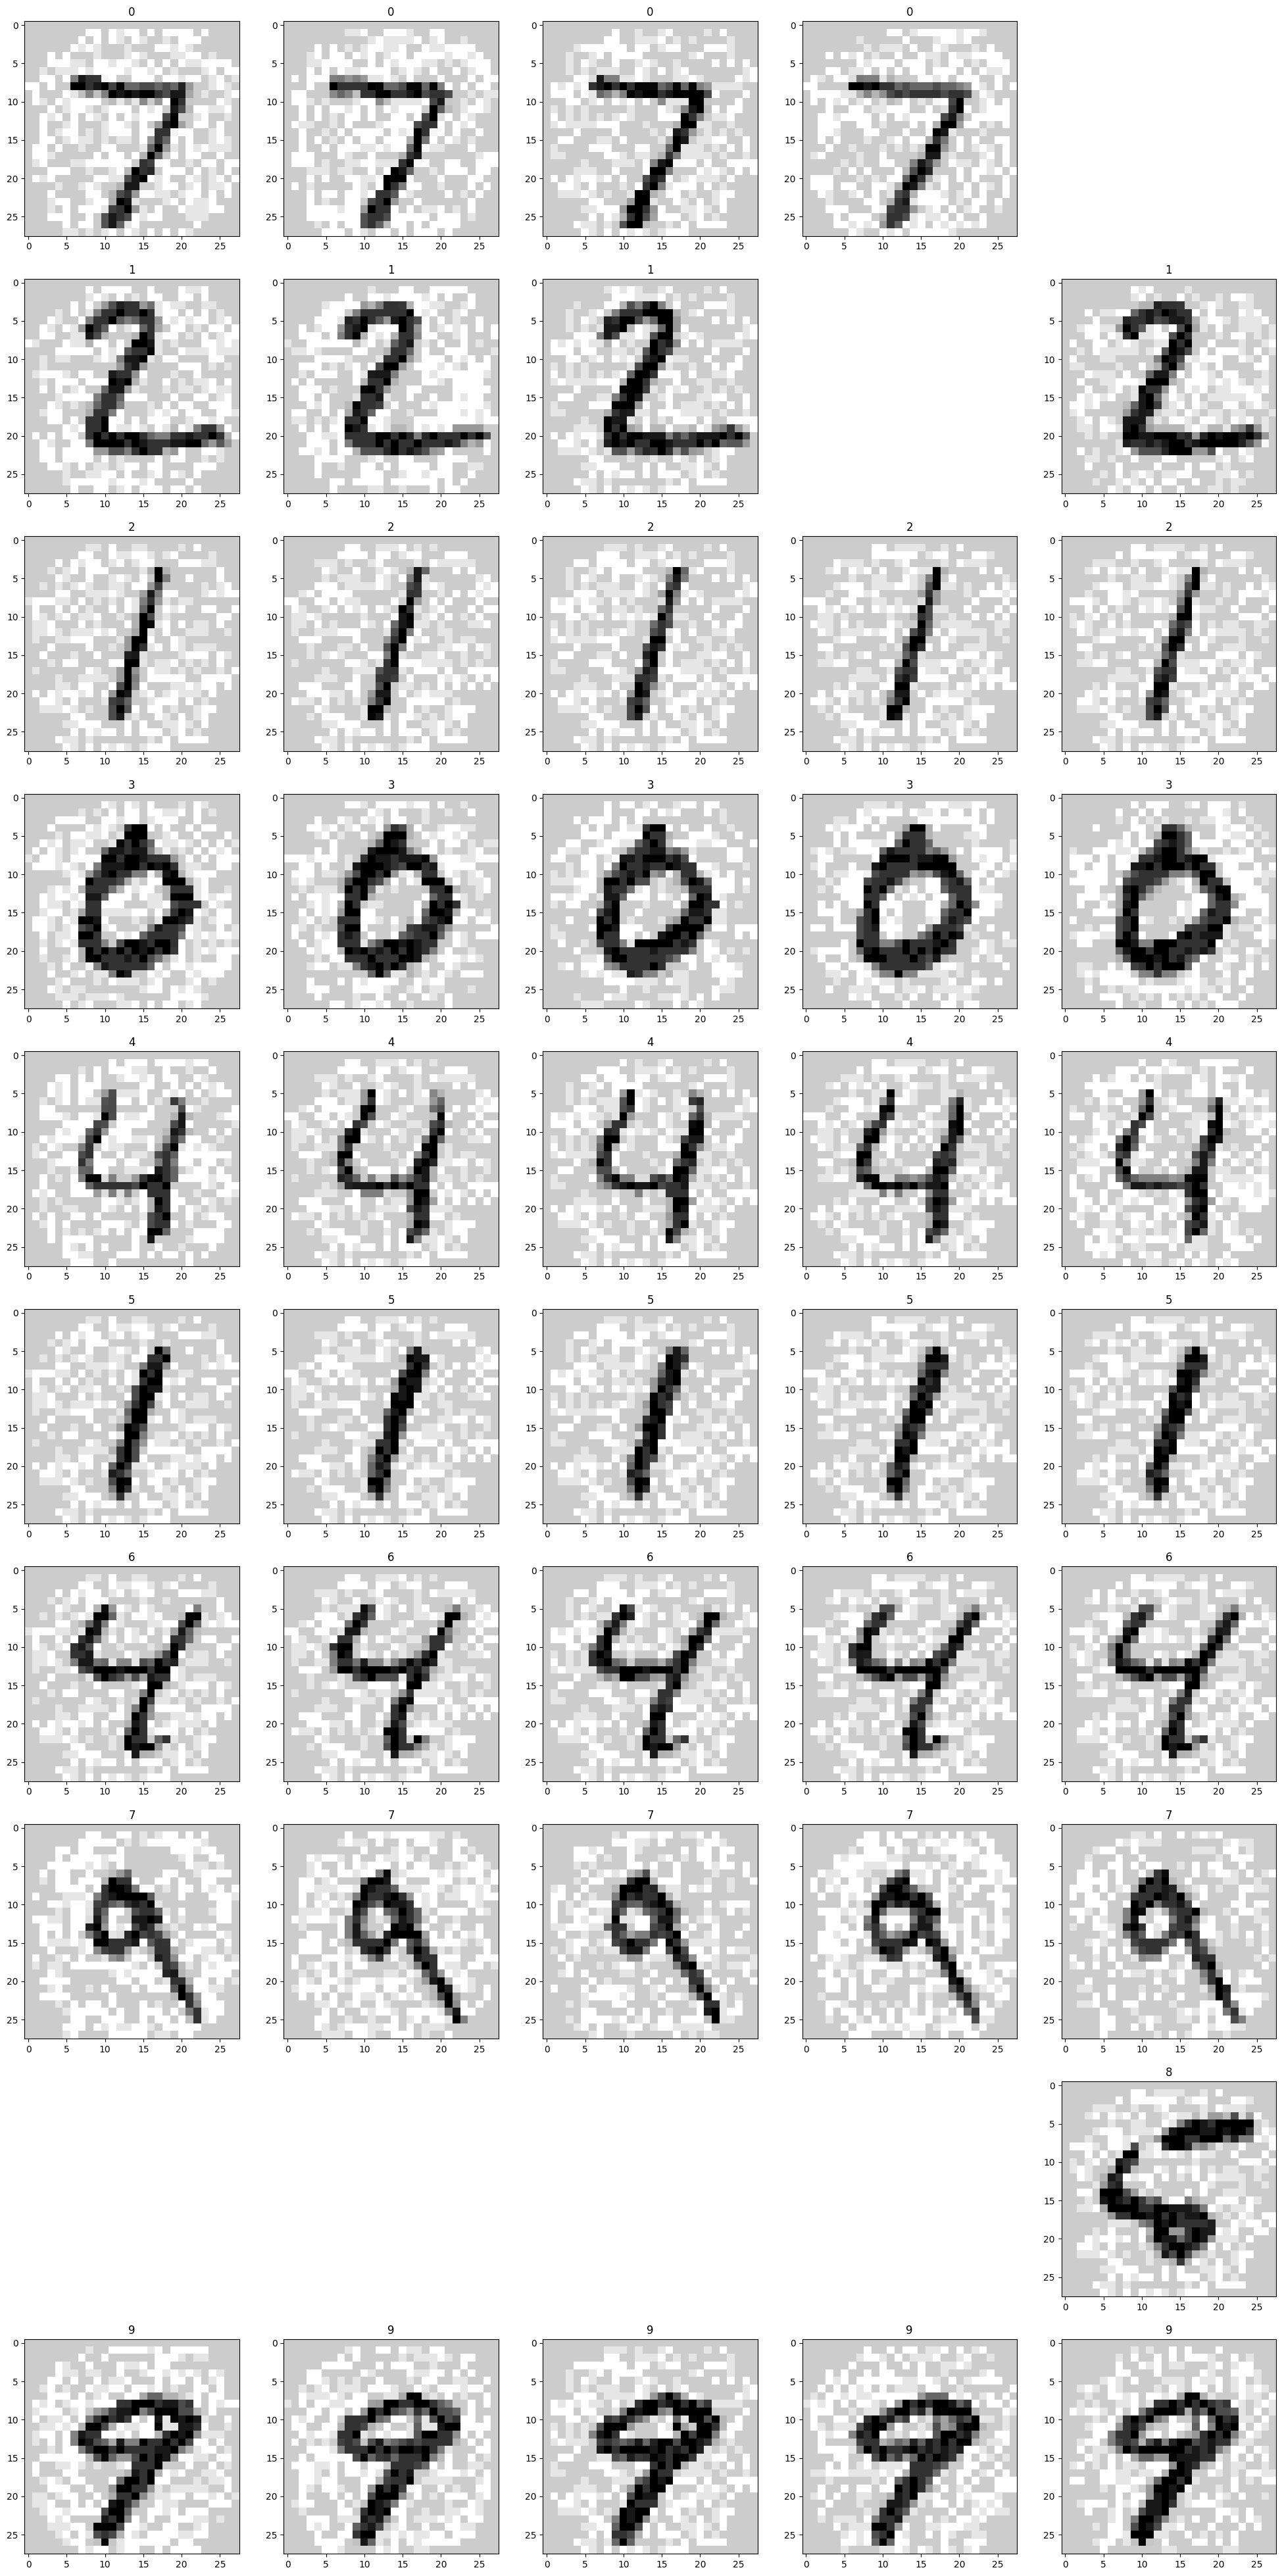

In [29]:

nrows = 10
ncols = 10

f = plt.figure(figsize=(nrows*5, ncols*5))
for i in range(10):
    for j in range(5):
        img = all_imgs[j][i]
        if type(img) != int:
            f.add_subplot(nrows, ncols, i*nrows + j+1)
            plt.title(str(i))
            plt.imshow(img.squeeze(), cmap="gray_r")
    



In [11]:
for model in models:
    test(test_dataloader, model, nn.CrossEntropyLoss())

Test error: 
 Accuracy: 92.5%   Avg loss: 0.301431
Test error: 
 Accuracy: 92.2%   Avg loss: 0.323945
Test error: 
 Accuracy: 93.0%   Avg loss: 0.290615
Test error: 
 Accuracy: 92.5%   Avg loss: 0.303251
Test error: 
 Accuracy: 92.4%   Avg loss: 0.296568


In [36]:
def compare_images(img1, img2):
    """returns the numbers of different pixels between the 2 images"""
    if type(img1) == int or type(img2) == int:
        # print("One of the image does not exist")
        return -1
    img1 = img1[0].flatten()
    img2 = img2[0].flatten()

    count = 0
    for i in range(len(img1)):
        if img1[i] != img2[i]:
            count += 1

    # print(f"Total different pixels : {count} / {len(img1)} [{100*count / len(img1):.3f}%]")
    return count / len(img1)


def print_matrix_cmp(comp):
    for i in range(n_models+1):
        if i == 0:
            s = "original :"
        else:
            s = f"model {i-1}  :"
        for j in range(n_models):
            s += f"\t {comp[i][j]:.3f}"
        s += "\n"
        print(s)


def proc_compare_images(all_imgs, idxs):
    for idx in idxs:
        comparisons = []
        original = dtest[idx][0]

        cmp = []
        for i in range(n_models):
            cmp.append(compare_images(all_imgs[i][idx], original))
        comparisons.append(cmp)

        for i in range(n_models):
            cmp = []
            img = all_imgs[i][idx]
            for j in range(n_models):
                cmp.append(compare_images(img, all_imgs[j][idx]))
            comparisons.append(cmp)
        # print(comparisons)
        print_matrix_cmp(comparisons)





proc_compare_images(all_imgs, [0])


# compare_images(all_imgs[0][0], dtest[0][0])

original :	 0.728	 0.710	 0.811	 0.724	 -1.000

model 0  :	 0.000	 0.532	 0.564	 0.543	 -1.000

model 1  :	 0.532	 0.000	 0.537	 0.536	 -1.000

model 2  :	 0.564	 0.537	 0.000	 0.514	 -1.000

model 3  :	 0.543	 0.536	 0.514	 0.000	 -1.000

model 4  :	 -1.000	 -1.000	 -1.000	 -1.000	 -1.000



## Test 11
#### train and test on both with eps 0.1

In [13]:
with open(f"{FILEPATH}/saved_generated_data/gendata_5000_eps0.1_m1_mnist_fixed.pickle", "rb") as file:
    adv_imgs1 = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/saved_idxs_set_5000_0.1.pickle", "rb") as file:
    adv_idxs1 = pickle.load(file)

Test with training on 0.1 and testing on 0.1

In [10]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs1[:1500], shuffle=True)
dtest.augment(adv_imgs1[1500:], shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 6500
Size of test set  : 11092


In [11]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.693521 [    0/ 6500]
loss : 0.412633 [ 6400/ 6500]
Test error: 
 Accuracy: 82.3%   Avg loss: 0.826374
Epoch 2
------------------------------
loss : 0.583024 [    0/ 6500]
loss : 0.324184 [ 6400/ 6500]
Test error: 
 Accuracy: 64.0%   Avg loss: 1.183407
Epoch 3
------------------------------
loss : 0.298311 [    0/ 6500]
loss : 0.217398 [ 6400/ 6500]
Test error: 
 Accuracy: 77.5%   Avg loss: 0.819345
Epoch 4
------------------------------
loss : 0.221926 [    0/ 6500]
loss : 0.141649 [ 6400/ 6500]
Test error: 
 Accuracy: 82.4%   Avg loss: 0.750216
Epoch 5
------------------------------
loss : 0.173241 [    0/ 6500]
loss : 0.104261 [ 6400/ 6500]
Test error: 
 Accuracy: 88.5%   Avg loss: 0.484543
Epoch 6
------------------------------
loss : 0.128997 [    0/ 6500]
loss : 0.097320 [ 6400/ 6500]
Test error: 
 Accuracy: 78.7%   Avg loss: 0.718207
Epoch 7
------------------------------
loss : 0.122341 [    0/ 6500]
loss : 0.081534 [ 6400/ 6500]
T

Test with training on 0.1 and testing on 0.2

In [16]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set, limit=5000)

dtrain.augment(adv_imgs1, shuffle=True)
dtest.augment(adv_imgs[:5000], shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 7592
Size of test set  : 10000


In [17]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.871423 [    0/ 7592]
loss : 0.621909 [ 6400/ 7592]
Test error: 
 Accuracy: 82.6%   Avg loss: 0.789729
Epoch 2
------------------------------
loss : 0.377745 [    0/ 7592]
loss : 0.357931 [ 6400/ 7592]
Test error: 
 Accuracy: 79.6%   Avg loss: 0.785632
Epoch 3
------------------------------
loss : 0.306709 [    0/ 7592]
loss : 0.245407 [ 6400/ 7592]
Test error: 
 Accuracy: 78.2%   Avg loss: 0.795700
Epoch 4
------------------------------
loss : 0.203104 [    0/ 7592]
loss : 0.135180 [ 6400/ 7592]
Test error: 
 Accuracy: 83.5%   Avg loss: 0.645360
Epoch 5
------------------------------
loss : 0.129836 [    0/ 7592]
loss : 0.111088 [ 6400/ 7592]
Test error: 
 Accuracy: 74.5%   Avg loss: 0.830994
Epoch 6
------------------------------
loss : 0.097353 [    0/ 7592]
loss : 0.081488 [ 6400/ 7592]
Test error: 
 Accuracy: 84.3%   Avg loss: 0.608634
Epoch 7
------------------------------
loss : 0.081937 [    0/ 7592]
loss : 0.081245 [ 6400/ 7592]
T

Test with training on 0.2 and testing on 0.1

In [18]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set, limit=5000)

dtrain.augment(adv_imgs[:5000], shuffle=True)
dtest.augment(adv_imgs1, shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 7592


In [19]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.699654 [    0/10000]
loss : 0.510108 [ 6400/10000]
Test error: 
 Accuracy: 78.3%   Avg loss: 0.873199
Epoch 2
------------------------------
loss : 0.419889 [    0/10000]
loss : 0.314560 [ 6400/10000]
Test error: 
 Accuracy: 82.5%   Avg loss: 0.687417
Epoch 3
------------------------------
loss : 0.221607 [    0/10000]
loss : 0.220800 [ 6400/10000]
Test error: 
 Accuracy: 86.2%   Avg loss: 0.561340
Epoch 4
------------------------------
loss : 0.160284 [    0/10000]
loss : 0.126139 [ 6400/10000]
Test error: 
 Accuracy: 87.4%   Avg loss: 0.492014
Epoch 5
------------------------------
loss : 0.101800 [    0/10000]
loss : 0.081677 [ 6400/10000]
Test error: 
 Accuracy: 89.0%   Avg loss: 0.426123
Epoch 6
------------------------------
loss : 0.079166 [    0/10000]
loss : 0.076601 [ 6400/10000]
Test error: 
 Accuracy: 87.5%   Avg loss: 0.458785
Epoch 7
------------------------------
loss : 0.082018 [    0/10000]
loss : 0.055116 [ 6400/10000]
T

## Test 12
#### test with shuffle of the original and adversarial images

In [5]:
dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000], shuffle=True)
dtest.augment(adv_imgs[5000:], shuffle=True)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 13766


In [6]:
model = Model1(input_size, output_size, quant_value)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=25, save=False)

Epoch 1
------------------------------
loss : 2.950751 [    0/10000]
loss : 0.564270 [ 6400/10000]
Test error: 
 Accuracy: 84.9%   Avg loss: 0.705768
Epoch 2
------------------------------
loss : 0.361665 [    0/10000]
loss : 0.318960 [ 6400/10000]
Test error: 
 Accuracy: 84.0%   Avg loss: 0.646749
Epoch 3
------------------------------
loss : 0.232181 [    0/10000]
loss : 0.207995 [ 6400/10000]
Test error: 
 Accuracy: 85.6%   Avg loss: 0.563495
Epoch 4
------------------------------
loss : 0.139735 [    0/10000]
loss : 0.123920 [ 6400/10000]
Test error: 
 Accuracy: 87.3%   Avg loss: 0.492386
Epoch 5
------------------------------
loss : 0.091425 [    0/10000]
loss : 0.090253 [ 6400/10000]
Test error: 
 Accuracy: 79.4%   Avg loss: 0.711118
Epoch 6
------------------------------
loss : 0.091918 [    0/10000]
loss : 0.079279 [ 6400/10000]
Test error: 
 Accuracy: 85.4%   Avg loss: 0.536431
Epoch 7
------------------------------
loss : 0.066293 [    0/10000]
loss : 0.096141 [ 6400/10000]
T

## Test 13
#### check robustness of adversarial images with a big epsilon

In [36]:
dtrain = Data(train_set, limit=10000)
dtest = Data(test_set)

# dtrain.augment(adv_imgs)

print(f"Size of train set : {len(dtrain)}")
print(f"Size of test set  : {len(dtest)}")

train_dataloader    = DataLoader(dtrain, batch_size=64)
test_dataloader     = DataLoader(dtest, batch_size=64)

Size of train set : 10000
Size of test set  : 10000


In [37]:
# create and train models
models = []
n_models = 5

for i in range(n_models):
    model = Model1(input_size, output_size, quant_value)
    train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)
    models.append(model.cvt_to_eval())
    print(f"finished model {i}")

finished model 0
finished model 1
finished model 2
finished model 3
finished model 4


In [38]:
def get_args_jupyter(eps, model):
    parser = argparse.ArgumentParser(
        description='evaluate robustness of 0/1 binaried network',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    init_argparser(parser)
    parser.add_argument('-e', '--eps', type=float, default=eps,    # classical value : 0.08
                        help='adv input eps on 0-1 scale')          # nb : modif from file required=True -> default=0.08
    parser.add_argument('--model', default=model)
    
    args = parser.parse_args(" ".split())
    return args

In [39]:
# create adv img for each model on the n first images

n_imgs = 10
all_imgs = []

eps = 0.5

for i in range(n_models):
    model = models[i]
    args = get_args_jupyter(eps, model)
    imgs_model = []
    for j in range(n_imgs):
        img, label = dtest[j]
        check_result, adv_img = search_adv_image(model, img, label, get_classes("MNIST"), args)
        if check_result == SolveResult.SAT:
            imgs_model.append(adv_img)
        else:
            imgs_model.append(-1)
    all_imgs.append(imgs_model)
    print(f"finished images for model {i}")

running build_ext
skipping '/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp' Cython extension (up-to-date)
skipping 'eevbnn._minisatcs' extension (up-to-date)
finished images for model 0
finished images for model 1
finished images for model 2
finished images for model 3
finished images for model 4


In [40]:
for i in range(5):
    idxs = []
    for j in range(n_imgs):
        if type(all_imgs[i][j]) != int:
            idxs.append(j)
        else:
            idxs.append("-")
    print(f"model {i} : {idxs}")

model 0 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 1 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 2 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 3 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]
model 4 : [0, 1, 2, 3, 4, 5, 6, 7, '-', 9]


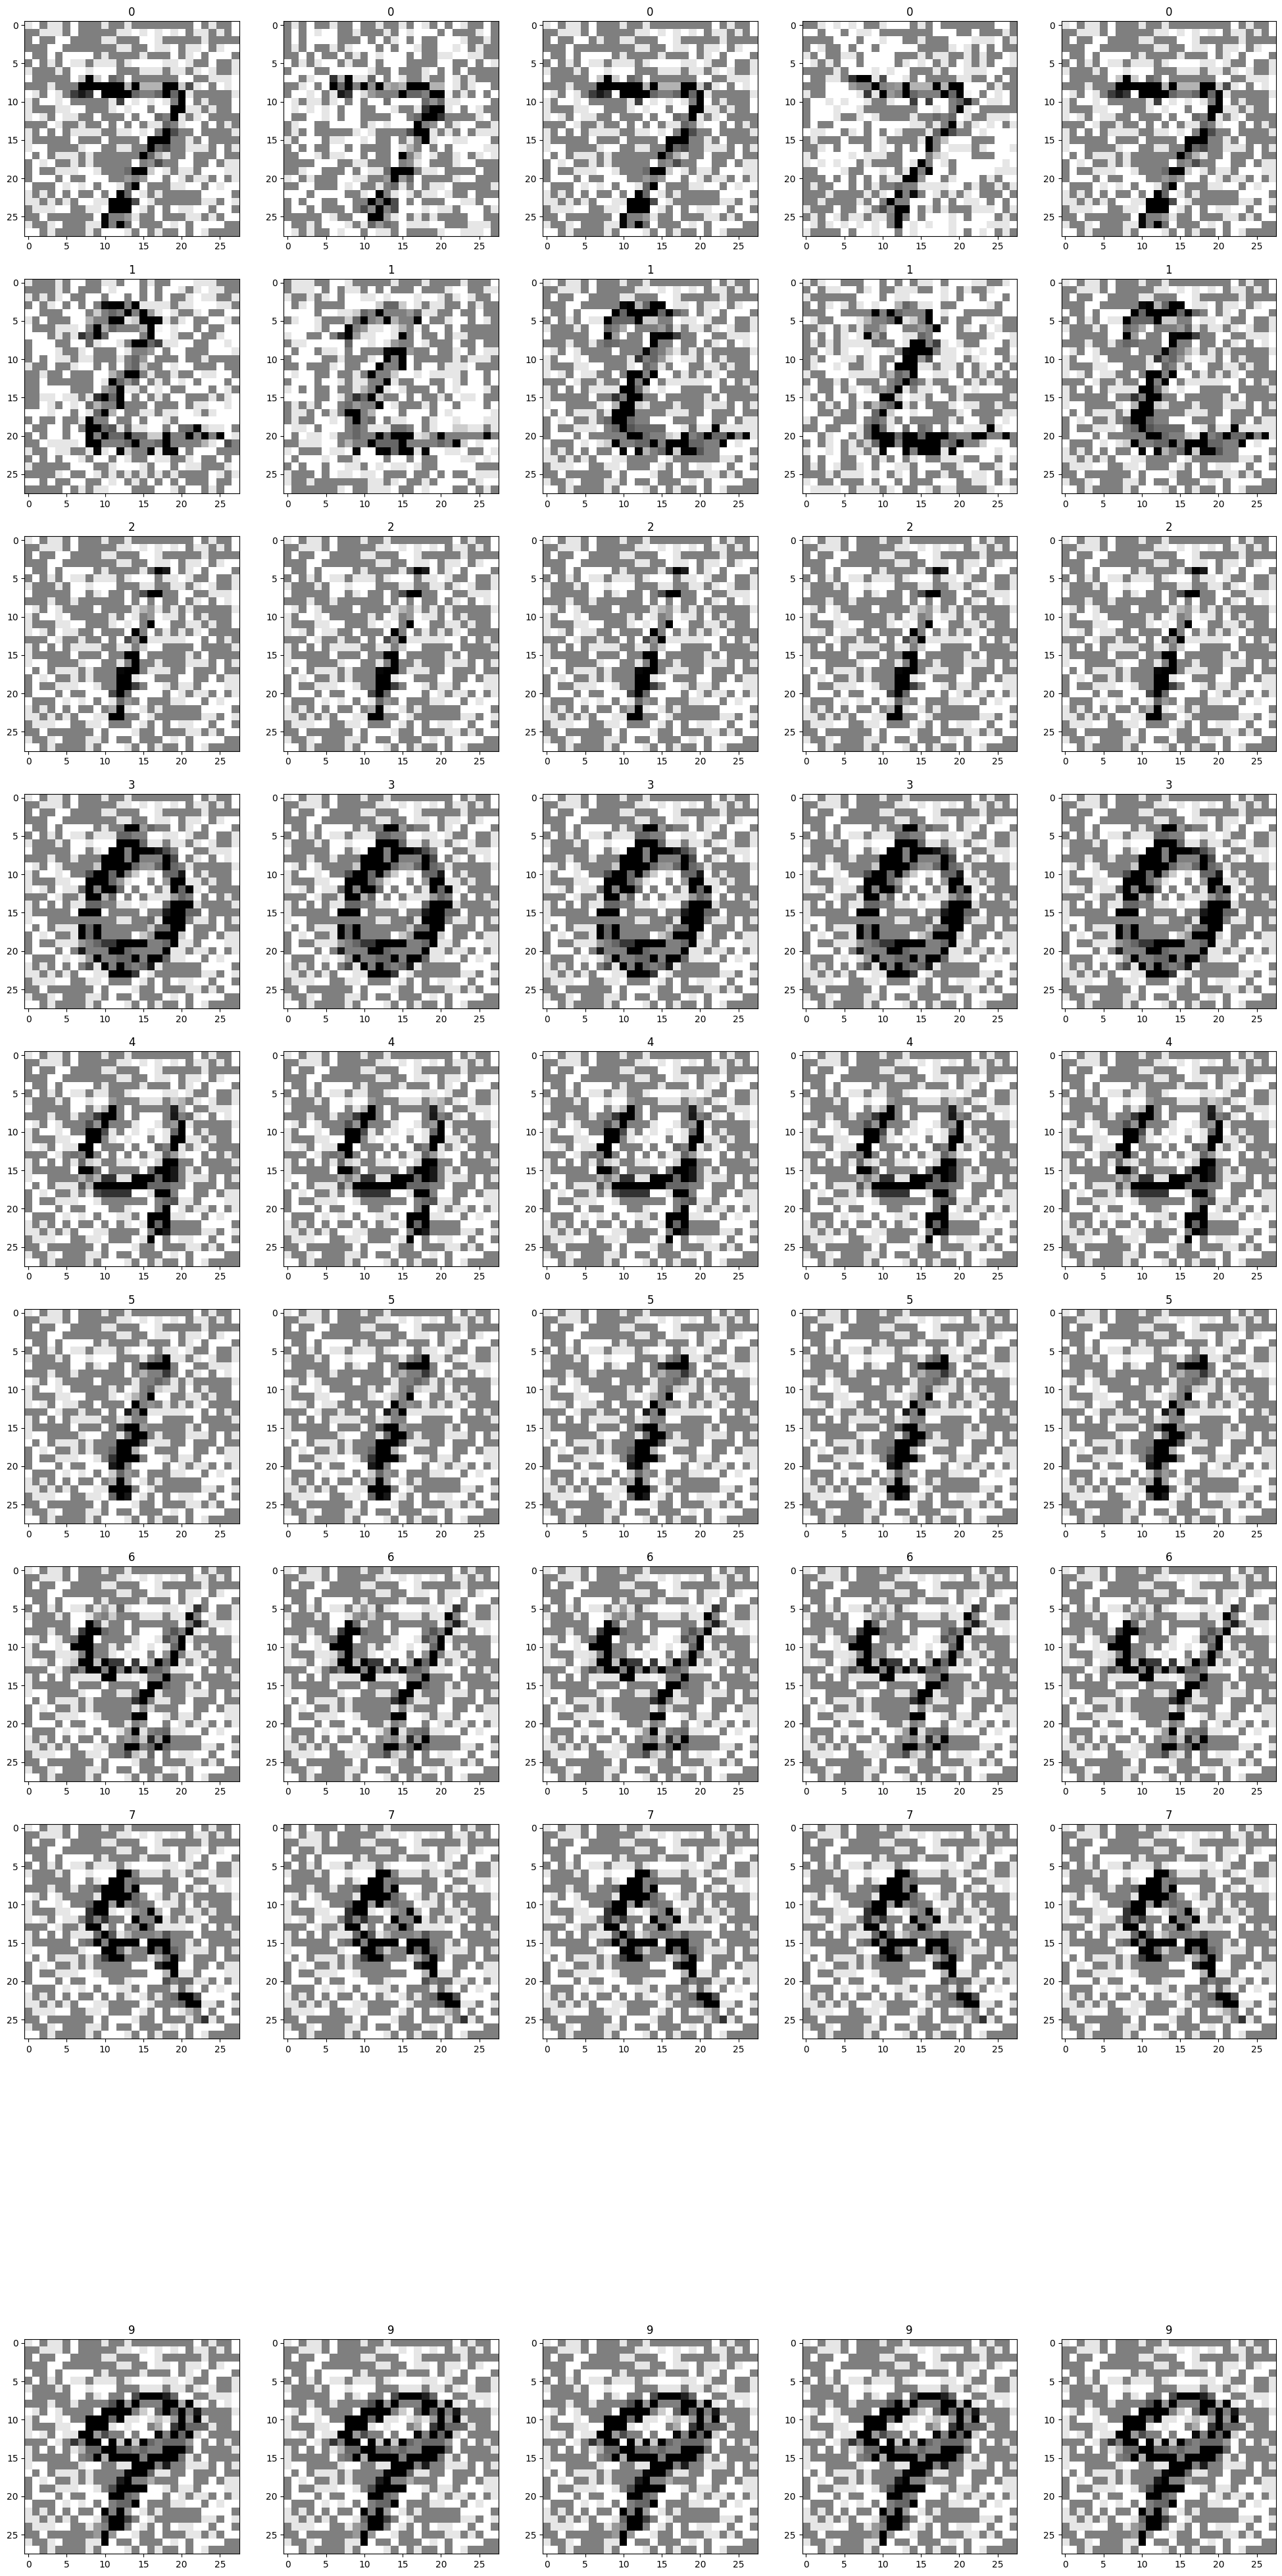

In [41]:
nrows = 10
ncols = 10

f = plt.figure(figsize=(nrows*5, ncols*5))
for i in range(10):
    for j in range(5):
        img = all_imgs[j][i]
        if type(img) != int:
            f.add_subplot(nrows, ncols, i*nrows + j+1)
            plt.title(str(i))
            plt.imshow(img.squeeze(), cmap="gray_r")

In [50]:
def compare_images(img1, img2):
    """returns the numbers of different pixels between the 2 images"""
    if type(img1) == int or type(img2) == int:
        # print("One of the image does not exist")
        return -1
    img1 = img1[0].flatten()
    img2 = img2[0].flatten()

    count = 0
    for i in range(len(img1)):
        if img1[i] != img2[i]:
            count += 1

    # print(f"Total different pixels : {count} / {len(img1)} [{100*count / len(img1):.3f}%]")
    return count / len(img1)


def print_matrix_cmp(comp):
    for i in range(n_models+1):
        if i == 0:
            s = "original :"
        else:
            s = f"model {i-1}  :"
        for j in range(n_models):
            s += f"\t {comp[i][j]:.3f}"
        s += "\n"
        print(s)


def proc_compare_images(all_imgs, idxs):
    for idx in idxs:
        comparisons = []
        original = dtest[idx][0]

        cmp = []
        for i in range(n_models):
            cmp.append(compare_images(all_imgs[i][idx], original))
        comparisons.append(cmp)

        for i in range(n_models):
            cmp = []
            img = all_imgs[i][idx]
            for j in range(n_models):
                cmp.append(compare_images(img, all_imgs[j][idx]))
            comparisons.append(cmp)
        # print(comparisons)
        print_matrix_cmp(comparisons)





proc_compare_images(all_imgs, [9])

original :	 0.792	 0.792	 0.792	 0.792	 0.792

model 0  :	 0.000	 0.000	 0.000	 0.000	 0.000

model 1  :	 0.000	 0.000	 0.000	 0.000	 0.000

model 2  :	 0.000	 0.000	 0.000	 0.000	 0.000

model 3  :	 0.000	 0.000	 0.000	 0.000	 0.000

model 4  :	 0.000	 0.000	 0.000	 0.000	 0.000



## Test 14

Test adv generation with multiple models

In [42]:

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)


models_verif = []

for i in range(5):
    model = Model1(input_size, output_size, quant_value)
    _ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)
    models_verif.append(model)


Epoch 1
------------------------------
loss : 2.726885 [    0/60000]
loss : 0.579754 [ 6400/60000]
loss : 0.499685 [12800/60000]
loss : 0.434103 [19200/60000]
loss : 0.314927 [25600/60000]
loss : 0.405883 [32000/60000]
loss : 0.242194 [38400/60000]
loss : 0.439022 [44800/60000]
loss : 0.177832 [51200/60000]
loss : 0.280459 [57600/60000]
Test error: 
 Accuracy: 93.7%   Avg loss: 0.262469
Epoch 2
------------------------------
loss : 0.188956 [    0/60000]
loss : 0.172081 [ 6400/60000]
loss : 0.209195 [12800/60000]
loss : 0.156515 [19200/60000]
loss : 0.131328 [25600/60000]
loss : 0.323330 [32000/60000]
loss : 0.096842 [38400/60000]
loss : 0.299353 [44800/60000]
loss : 0.190390 [51200/60000]
loss : 0.212465 [57600/60000]
Test error: 
 Accuracy: 94.1%   Avg loss: 0.207765
Epoch 3
------------------------------
loss : 0.103827 [    0/60000]
loss : 0.137045 [ 6400/60000]
loss : 0.116567 [12800/60000]
loss : 0.107076 [19200/60000]
loss : 0.107421 [25600/60000]
loss : 0.195529 [32000/60000]
l

In [43]:
def verify_img_mult_models(models, img, true_label, args):
    
    verifier = ModelVerifier(args, models, show_logs=False)

    img = torch_as_npy(img)
    true_label = np.array(true_label)

    check_result, (time_build, time_verif), inp_adv, clsfy_scores = verifier.check(img, true_label)

    return check_result, inp_adv

In [51]:
models_eval = []
for model in models_verif:
    models_eval.append(model.cvt_to_eval())


adv_imgs_mul = []
args = get_args_jupyter(0.3, models_eval)


for i in range(10):
    img, label = test_set[i]
    check_res, inp_adv = verify_img_mult_models(models_eval, img, label, args)
    if check_res == SolveResult.SAT:
        adv_imgs_mul.append(torch.from_numpy(inp_adv.reshape(1, 1, 28, 28)))
    else:
        adv_imgs_mul.append("-")



In [52]:
classes = get_classes("MNIST")

def check_class_adv_img(models, imgs):
    for i, model in enumerate(models):
        s = f"model {i} :"
        for img in imgs:
            if img != "-":
                pred = model(img)[0]
                label = classes[pred.argmax(0)]
                s += f" {label}"
            else:
                s += " -"
        print(s)


check_class_adv_img(models_verif, adv_imgs_mul)


model 0 : 3 5 6 2 6 7 8 3 6 3
model 1 : 3 5 6 2 6 7 8 3 6 3
model 2 : 3 5 6 2 6 7 8 3 6 3
model 3 : 3 5 6 2 6 7 8 3 6 3
model 4 : 3 5 6 2 6 7 8 3 6 3


In [54]:
models_check = []

for i in range(5):
    model = Model1(input_size, output_size, quant_value)
    _ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)
    models_check.append(model)

In [55]:
check_class_adv_img(models_check, adv_imgs_mul)

model 0 : 3 5 6 2 6 7 6 5 6 3
model 1 : 3 5 6 3 3 3 8 3 2 3
model 2 : 7 2 7 2 6 7 8 3 6 3
model 3 : 3 3 3 2 6 3 8 3 6 3
model 4 : 3 5 6 2 6 3 5 3 6 3


In [57]:
with open(f"{FILEPATH}/saved_models_eevbnn/list_models1_mnist.pickle", "wb") as file:
    pickle.dump(models_verif, file)

Do the same for FASHION dataset

In [5]:
train_set, test_set = load_data("Fashion")

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)


models_verif = []

for i in range(5):
    model = Model1(input_size, output_size, quant_value)
    _ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)
    models_verif.append(model)

with open(f"{FILEPATH}/saved_models_eevbnn/list_models1_fashion.pickle", "wb") as file:
    pickle.dump(models_verif, file)




Epoch 1
------------------------------
loss : 2.929455 [    0/60000]
loss : 0.789776 [ 6400/60000]
loss : 0.535301 [12800/60000]
loss : 0.769289 [19200/60000]
loss : 0.674572 [25600/60000]
loss : 0.477542 [32000/60000]
loss : 0.363539 [38400/60000]
loss : 0.580747 [44800/60000]
loss : 0.517843 [51200/60000]
loss : 0.544972 [57600/60000]
Test error: 
 Accuracy: 84.1%   Avg loss: 0.480651
Epoch 2
------------------------------
loss : 0.334313 [    0/60000]
loss : 0.404180 [ 6400/60000]
loss : 0.348366 [12800/60000]
loss : 0.354014 [19200/60000]
loss : 0.421028 [25600/60000]
loss : 0.375767 [32000/60000]
loss : 0.320369 [38400/60000]
loss : 0.500855 [44800/60000]
loss : 0.416469 [51200/60000]
loss : 0.452929 [57600/60000]
Test error: 
 Accuracy: 84.3%   Avg loss: 0.439778
Epoch 3
------------------------------
loss : 0.276340 [    0/60000]
loss : 0.359585 [ 6400/60000]
loss : 0.313199 [12800/60000]
loss : 0.363904 [19200/60000]
loss : 0.328297 [25600/60000]
loss : 0.325098 [32000/60000]
l

do the same for CIFAR

In [2]:
train_set, test_set = load_data("CIFAR10")

input_size = 32*32*3
output_size = 10
quant_value = 0.1

train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)


models_verif = []

for i in range(5):
    model = Model1(input_size, output_size, quant_value)
    _ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)
    models_verif.append(model)

with open(f"{FILEPATH}/saved_models_eevbnn/list_models1_cifar.pickle", "wb") as file:
    pickle.dump(models_verif, file)

Epoch 1
------------------------------
loss : 2.645082 [    0/50000]
loss : 1.959309 [ 6400/50000]
loss : 1.582783 [12800/50000]
loss : 1.849905 [19200/50000]
loss : 1.855007 [25600/50000]
loss : 1.752345 [32000/50000]
loss : 1.829765 [38400/50000]
loss : 1.597141 [44800/50000]
Test error: 
 Accuracy: 42.5%   Avg loss: 1.657297
Epoch 2
------------------------------
loss : 1.707724 [    0/50000]
loss : 1.582954 [ 6400/50000]
loss : 1.408934 [12800/50000]
loss : 1.667979 [19200/50000]
loss : 1.639521 [25600/50000]
loss : 1.589501 [32000/50000]
loss : 1.702895 [38400/50000]
loss : 1.530171 [44800/50000]
Test error: 
 Accuracy: 45.5%   Avg loss: 1.565267
Epoch 3
------------------------------
loss : 1.725008 [    0/50000]
loss : 1.536784 [ 6400/50000]
loss : 1.329845 [12800/50000]
loss : 1.443557 [19200/50000]
loss : 1.483331 [25600/50000]
loss : 1.577819 [32000/50000]
loss : 1.550918 [38400/50000]
loss : 1.353926 [44800/50000]
Test error: 
 Accuracy: 47.8%   Avg loss: 1.502665
Epoch 4
--

## Test 15
#### do not stop after one adv img

In [29]:
# import
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from eevbnn.satenv import SolveResult
from eevbnn.eval_bin import ModelVerifier, init_argparser
from eevbnn.net_bin import BinLinear, BinConv2d, BinConv2dPos, BinLinearPos, InputQuantizer, MnistMLP, TernaryWeightWithMaskFn, SeqBinModelHelper, Binarize01Act, BatchNormStatsCallbak, setattr_inplace
from eevbnn.utils import Flatten, ModelHelper, torch_as_npy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pickle
import time
import random

from eevbnn_figures import *
from eevbnn_models import *
from eevbnn_verif import *
from eevbnn_augmentation import *

train_set, test_set = load_data("MNIST")

model = load_model(1, "MNIST", 0.1, False)
model = model.cvt_to_eval()


def get_args_jupyter(eps, model):
    parser = argparse.ArgumentParser(
        description='evaluate robustness of 0/1 binaried network',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    init_argparser(parser)
    parser.add_argument('-e', '--eps', type=float, default=eps,    # classical value : 0.08
                        help='adv input eps on 0-1 scale')          # nb : modif from file required=True -> default=0.08
    parser.add_argument('--model', default=model)
    
    args = parser.parse_args(" ".split())
    return args

running build_ext
cythoning /home/ben/Documents/Masters_thesis/eevbnn/eevbnn/_minisatcs.pyx to /home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp
building 'eevbnn._minisatcs' extension
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/ben/Documents/Masters_thesis/venv/include -I/usr/include/python3.10 -c /home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp -o /home/ben/.pyxbld/temp.linux-x86_64-3.10/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.o -O2 -ggdb -I/home/ben/Documents/Masters_thesis/eevbnn/eevbnn/minisatcs -I/home/ben/Documents/Masters_thesis/eevbnn/eevbnn -std=c++17
x86_64-linux-gnu-g++ -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 -Wl,-Bsymbolic-functions -g -fwrapv -O2 -g -

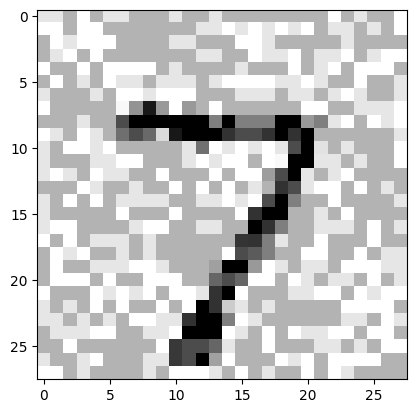

In [30]:
args = get_args_jupyter(0.3, model)
verifier = ModelVerifier(args, [model], show_logs=False)

img, true_label = test_set[0]
img = torch_as_npy(img)
true_label = np.array(true_label)

check_result, (time_build, time_verif), inp_adv, clsfy_scores = verifier.check(img, true_label)
# adv_count = verifier.check(img, true_label, with_count=True)
# print(adv_count)

print(check_result)
plt.imshow(inp_adv.squeeze(), cmap="gray_r")

## Test 16

test model 1 with an "adv" label

In [2]:
input_size = 28*28
output_size = 11

train_set, test_set = load_data("MNIST")
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)
classes = get_classes("MNIST", with_uncertain=True)

model = Model1(input_size, output_size, quant_value=0.1)

train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)


Epoch 1
------------------------------
loss : 3.017209 [    0/60000]
loss : 0.597654 [ 6400/60000]
loss : 0.500624 [12800/60000]
loss : 0.463268 [19200/60000]
loss : 0.385753 [25600/60000]
loss : 0.492196 [32000/60000]
loss : 0.233969 [38400/60000]
loss : 0.453490 [44800/60000]
loss : 0.208366 [51200/60000]
loss : 0.293957 [57600/60000]
Test error: 
 Accuracy: 92.8%   Avg loss: 0.274023
Epoch 2
------------------------------
loss : 0.210977 [    0/60000]
loss : 0.210130 [ 6400/60000]
loss : 0.206479 [12800/60000]
loss : 0.192076 [19200/60000]
loss : 0.155718 [25600/60000]
loss : 0.384020 [32000/60000]
loss : 0.081348 [38400/60000]
loss : 0.441024 [44800/60000]
loss : 0.117933 [51200/60000]
loss : 0.113515 [57600/60000]
Test error: 
 Accuracy: 95.1%   Avg loss: 0.184141
Epoch 3
------------------------------
loss : 0.156849 [    0/60000]
loss : 0.130565 [ 6400/60000]
loss : 0.143272 [12800/60000]
loss : 0.113145 [19200/60000]
loss : 0.101320 [25600/60000]
loss : 0.249104 [32000/60000]
l

Model1(
  (features): Sequential(
    (0): InputQuantizer(0.1)
    (1): Flatten()
    (2): BinLinearPos(in_features=784, out_features=512, bias=False)
    (3): BatchNormStatsCallbak(512, scalar=False, cbd=0)
    (4): Binarize01Act()
    (5): BinLinearPos(in_features=512, out_features=512, bias=False)
    (6): BatchNormStatsCallbak(512, scalar=False, cbd=1)
    (7): Binarize01Act()
    (8): BinLinearPos(in_features=512, out_features=100, bias=False)
    (9): BatchNormStatsCallbak(100, scalar=False, cbd=1)
    (10): Binarize01Act()
    (11): BinLinearPos(in_features=100, out_features=11, bias=False)
    (12): BatchNormStatsCallbak(11, scalar=True, cbd=0)
  )
)

In [2]:
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    adv_imgs = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_TEST_fixed.pickle", "rb") as file:
    adv_imgs_test = pickle.load(file)

In [3]:
def evaluate_acc(model, imgs, dataset_name="MNIST", with_uncertain=False):
    """
    Evaluate the robustness of a model based on its accuracy on adversarial images

    Parameters:
        - model : the model we want to evaluate
        - imgs : the (adversarial) images used to compute the accuracy, format : [(image, label)]
    """
    score = 0
    n_adv_wrong = 0
    classes = get_classes(dataset_name, with_uncertain=with_uncertain)
    model.eval()
    with torch.no_grad():
        for img, true_label in imgs:
            if dataset_name == "CIFAR10":
                pred = model(img.reshape(1, 3, 32, 32))[0]
            else:
                pred = model(img.reshape(1, 1, 28, 28))[0]
            pred = classes[pred.argmax(0)]

            if pred == classes[true_label]:
                score += 1
            elif classes[true_label] == "adv":
                n_adv_wrong += 1
            # else:
            #     print(f"true : {classes[true_label]}, pred : {pred}")

    return 100 * score / len(imgs), n_adv_wrong

In [4]:
tr = []
te = []

for i in range(len(adv_imgs)):
    tr.append((adv_imgs[i][0], 10))
for i in range(len(adv_imgs_test)):
    te.append((adv_imgs_test[i][0], 10))

adv_imgs = tr
adv_imgs_test = te

In [8]:
train_set, test_set = load_data("MNIST")
input_size = 28*28
output_size = 11

dtrain = Data(train_set, limit=5000)
dtest = Data(test_set)

dtrain.augment(adv_imgs[:5000], shuffle=True)

train_dataloader = DataLoader(dtrain, batch_size=64)
test_dataloader = DataLoader(dtest, batch_size=64)

model = Model1(input_size, output_size)
_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False)


Epoch 1
------------------------------
loss : 3.167747 [    0/10000]
loss : 0.585336 [ 6400/10000]
Test error: 
 Accuracy: 85.7%   Avg loss: 0.645217
Epoch 2
------------------------------
loss : 0.394387 [    0/10000]
loss : 0.385974 [ 6400/10000]
Test error: 
 Accuracy: 86.1%   Avg loss: 0.582761
Epoch 3
------------------------------
loss : 0.224067 [    0/10000]
loss : 0.285114 [ 6400/10000]
Test error: 
 Accuracy: 85.2%   Avg loss: 0.588248
Epoch 4
------------------------------
loss : 0.146591 [    0/10000]
loss : 0.210274 [ 6400/10000]
Test error: 
 Accuracy: 80.2%   Avg loss: 0.716126
Epoch 5
------------------------------
loss : 0.128688 [    0/10000]
loss : 0.174259 [ 6400/10000]
Test error: 
 Accuracy: 84.5%   Avg loss: 0.579744


In [9]:
score_adv, _ = evaluate_acc(model, adv_imgs_test, with_uncertain=True)
score, n_adv_wrong = evaluate_acc(model, dtest, with_uncertain=True)
print(f" score : {score}\n n_adv_wrong : {n_adv_wrong}\n ---\n score_adv : {score_adv}")

 score : 84.53
 n_adv_wrong : 0
 ---
 score_adv : 100.0


In [10]:
with open(f"{FILEPATH}/saved_generated_data/gendata_20000_eps0.2_mS1_mnist_fixed.pickle", 'rb') as file:
    adv02 = pickle.load(file)

a = []
for i in range(len(adv02)):
    a.append((adv02[i][0], 10))
adv02 = a

In [11]:
score02, nwrong02 = evaluate_acc(model, adv02, with_uncertain=True)
print(f"score 0.2 : {score02}\nn_adv_wrong 0.2 : {nwrong02}")

score 0.2 : 87.26114649681529
n_adv_wrong 0.2 : 1360


## Test 17

robustness metrics

In [3]:
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_TEST_fixed.pickle", "rb") as file:
    adv_imgs_test = pickle.load(file)

In [11]:
from scipy.special import softmax

In [43]:
def absolute_eval_robustness(model, imgs, dataset_name="MNIST", with_uncertain=False):
    score = 0
    classes = get_classes(dataset_name, with_uncertain=with_uncertain)
    model.eval()
    n_correct = 0
    with torch.no_grad():
        for img, true_label in imgs:
            if dataset_name == "CIFAR10":
                pred = model(img.reshape(1, 3, 32, 32))[0]
            else:
                pred = model(img.reshape(1, 1, 28, 28))[0]
            pred = softmax(pred)
            
            score += (1 - abs(pred[true_label] - max(pred)))
            if true_label == pred.argmax(0):
                n_correct += 1

    score /= len(imgs)
    n_correct /= len(imgs)
    return score, n_correct


def ratio_eval_robustness(model, imgs, dataset_name="MNIST", with_uncertain=False):
    score = 0
    n_correct = 0
    model.eval()
    with torch.no_grad():
        for img, true_label in imgs:
            if dataset_name == "CIFAR10":
                pred = model(img.reshape(1, 3, 32, 32))[0]
            else:
                pred = model(img.reshape(1, 1, 28, 28))[0]
            pred = softmax(pred)

            score += (max(pred) / (1 - pred[true_label]))

            if true_label == pred.argmax(0):
                n_correct += 1
    
    score /= len(imgs)
    n_correct /= len(imgs)
    return score, n_correct

def ratio_rev_eval_robustness(model, imgs, dataset_name="MNIST", with_uncertain=False):
    score = 0
    n_correct = 0
    model.eval()
    with torch.no_grad():
        for img, true_label in imgs:
            if dataset_name == "CIFAR10":
                pred = model(img.reshape(1, 3, 32, 32))[0]
            else:
                pred = model(img.reshape(1, 1, 28, 28))[0]
            pred = softmax(pred)

            score += (pred[true_label] / (1 - max(pred)))

            if true_label == pred.argmax(0):
                n_correct += 1
    
    score /= len(imgs)
    n_correct /= len(imgs)
    return score, n_correct


In [45]:
input_size = 28*28
output_size = 10

train_set, test_set = load_data("MNIST")
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)
classes = get_classes("MNIST", with_uncertain=True)

model = Model1(input_size, output_size, quant_value=0.1)

_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)

In [46]:
t = Data(adv_imgs_test, limit=2000)

rob, acc = absolute_eval_robustness(model, t, "MNIST")
print(rob*100, acc*100)

rob, acc = ratio_eval_robustness(model, t, "MNIST")
print("---")
print(rob, acc*100)

rob, acc = ratio_rev_eval_robustness(model, t)
print("---")
print(rob, acc*100)

44.710101490467785 8.4
---
0.8801763928726763 8.4
---
0.39825030168174996 8.4


In [47]:
input_size = 28*28
output_size = 10

with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    adv_imgs = pickle.load(file)

train_set, test_set = load_data("MNIST")

dtrain = Data(train_set, limit=10000)
dtrain.augment(adv_imgs[:10000])


train_dataloader = DataLoader(dtrain, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)
classes = get_classes("MNIST", with_uncertain=True)

model = Model1(input_size, output_size, quant_value=0.1)

_ = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)

In [48]:
t = Data(adv_imgs_test)
rob, acc = absolute_eval_robustness(model, t, "MNIST")
print(rob*100, acc*100)

rob, acc = ratio_eval_robustness(model, t, "MNIST")
print('---')
print(rob, acc*100)

rob, acc = ratio_rev_eval_robustness(model, t)
print('---')
print(rob, acc*100)

90.29644855618722 80.6967213114754
---
22.56077458349442 80.6967213114754
---
22.48648137603052 80.6967213114754


In [49]:
te = Data(test_set)
r, a = absolute_eval_robustness(model, te, "MNIST")
print(r, a)

r, a = ratio_eval_robustness(model, te)
print('---')
print(r, a)

r, a = ratio_rev_eval_robustness(model, te)
print('---')
print(r, a)

0.9458194414928556 0.8999
---
35.504064105769686 0.8999
---
35.46368074754511 0.8999
